<a href="https://colab.research.google.com/github/z-devin/Remote-Sensing/blob/main/In_Season_Crop_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 2
- ECE471: Fundamentals of Remote Sensing and Earth Observation
- Spring 2025
- Instructor: Krishna Karra
- Contact: krishna.karra@cooper.edu (Teams chat is quickest)
- Assigned: Wednesday, February 26, 2025
- Due: Tuesday, March 18, 2025 (by midnight EST)

## Problem Motivation

The United States Department of Agriculture (USDA), in conjunction with the United States Geological Survey (USGS), produces the Cropland Data Layer (CDL), an annual landcover map of crop types across the Continental United States at 30-meter resolution. This map, which incorporates Landsat and Sentinel imagery from across the year, represents some of the highest quality, rigorously validated land cover classification that can be found anywhere.

A year's annual map is usually released a few months into the next year (e.g. the 2020 CDL is released towards the end of the first quarter of 2021). As a geospatial consultant, your task is to investigate whether certain crop types could be predicted *in-season* (e.g. without using a full year's worth of imagery).

The CDL is used within government and industry for crop health monitoring, crop area estimation, agricultural policy development, environmental monitoring, yield forecasting and more. In-season prediction of crop types would be vastly useful for all of these applications.

For this pilot study, the focus will be on Iowa and Illinois.

## Problem Overview

The overall workflow will be:

1. Analyze cropland data to identify the 5 most prevalent crops grown in Iowa and Illinois.
2. Explore and visualize the seasonal patterns of those 5 crops using vegetation index time series analysis.
3. Develop a crop identification model that takes satellite imagery as input and predicts crop type at the pixel level.
4. Assess model performance using validation data and metrics.
5. Apply the model to full counties to produce crop type maps and compare against ground truth data.

The core data sources will be:

1. Cropland Data Layer (CDL) for crop type ground truth labels
2. Landsat satellite imagery for model inputs
3. Google Earth Engine (GEE) platform for analysis and modeling

This assignment will give you real, concrete experience with:

- Working with large-scale geospatial data
- Time series analysis of vegetation indices
- Developing and validating a remote sensing model
- Creating meaningful data visualizations and maps

Your modeling approach and additional data sources are flexible. The key deliverables are: ranked crop list, crop seasonal analysis, trained crop identification model, model evaluations, and final county-level crop maps.

## Task 1: Identify Most Prevalent Crops

###*Goal: Plan to have made significant progress on Task 1 (or completed it) by March 5.*

The goal of this task is to create a ranked list of the most commonly grown crops across Iowa and Illinois based on acreage data from the 2019 Cropland Data Layer (CDL).

Specifically, you should:

1. Load the 2019 CDL raster data for the 2 states from Google Earth Engine.
2. Write a script to calculate the total acreage of each unique crop type in the CDL legend across the 2 states.
3. Rank the crops based on total acreage from most to least.
4. Output the list as a CSV file with two columns: Crop Name and Total Acres. Include the top 20 crops. Include the top 20 crops.
5. From this list, select the top 5 most prevalent crops. These will be the focus for the rest of the analysis.

Things to keep in mind:

1. Analysis must be done programmatically using GEE.
2. Output must be a clean CSV file with the columns specified.
3. Make sure to handle any data filtering or preprocessing steps like reprojections.
4. Document your methodology and thought process

# Imports and Map Setup
I chose the full 2019 year's worth of satellite imagery using only tier 2 images for better quality.

I may think about adding tier 1 images if I have time.

In [ ]:
import ee
import geemap
import pandas as pd

ee.Authenticate()
ee.Initialize(project='ee-devinzhangstudent')

In [ ]:
m = geemap.Map()

In [ ]:
m

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

# Implementing State Borders
I tried finding the state borders for 2019 but they didn't have that info. However, 2018 should be okay as the state borders do not change very often.

In [ ]:
states = ee.FeatureCollection('TIGER/2018/States')
roi_illinois = states.filter(ee.Filter.eq('STATEFP', '17')).geometry()
roi_iowa = states.filter(ee.Filter.eq('STATEFP', '19')).geometry()
combined_roi = roi_illinois.union(roi_iowa)

m.addLayer(roi_illinois,{},'Illinois Border')
m.addLayer(roi_iowa,{},'Iowa Border')

For the NAIP we use .mosaic() to stack the images into a single one and then clip it to our roi, Illinois and Iowa.

In [ ]:
naip = ee.ImageCollection('USDA/NAIP/DOQQ')
naip = naip.filterDate('2019-01-01', '2019-12-31')
naip_illinois = naip.mosaic().clip(roi_illinois)
naip_iowa = naip.mosaic().clip(roi_iowa)

m.addLayer(naip_illinois, {'bands': ['R', 'G', 'B'], 'min': 0, 'max': 255}, "NAIP Illinois")
m.addLayer(naip_iowa, {'bands': ['R', 'G', 'B'], 'min': 0, 'max': 255}, "NAIP Iowa")

The layer visually looks good.

# CDL Classification + Reprojection

I decided to use CDL for the land cover classification and reproject the map to EPSG:5070 to preserve area because we will need to do area calculations later.

In [ ]:
cdl_2019 = ee.Image('USDA/NASS/CDL/2019').select('cropland')
cdl_2019 = cdl_2019.reproject('EPSG:5070', scale=30)
cdl_2019 = cdl_2019.clip(roi_illinois.union(roi_iowa))
cdl_2019_vis = {
    'min': 1,
    'max': 254,
    'palette': ['000000', 'ffff00', '1c6330', '66a266', 'd3ffbe', 'ff0000', '00ff00', '0000ff']
}

m.addLayer(cdl_2019, cdl_2019_vis, 'CDL 2019')


# Area Calculations and Output to CSV

To begin the area calculations, we need to have a legend of all values from the CDL Dataset.

In [ ]:
crop_names = cdl_2019.get('cropland_class_names').getInfo()
crop_values = cdl_2019.get('cropland_class_values').getInfo()
crop_names = crop_names.split(',')
crop_values = [int(value) for value in crop_values.split(',')]
crop_legend = dict(zip(crop_values, crop_names))

values_to_remove = {0, 61, 63, 64, 65, 81, 82, 83, 87, 88, 92, 111, 112,  121, 122, 123, 124, 131, 141, 142, 143, 152, 176, 190, 195, 37,  26,  225, 226, 228, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 254}

crop_legend = {key: value for key, value in crop_legend.items() if key not in values_to_remove}
print(crop_legend)

{1: 'Corn', 2: 'Cotton', 3: 'Rice', 4: 'Sorghum', 5: 'Soybeans', 6: 'Sunflower', 10: 'Peanuts', 11: 'Tobacco', 12: 'Sweet Corn', 13: 'Pop or Orn Corn', 14: 'Mint', 21: 'Barley', 22: 'Durum Wheat', 23: 'Spring Wheat', 24: 'Winter Wheat', 25: 'Other Small Grains', 27: 'Rye', 28: 'Oats', 29: 'Millet', 30: 'Speltz', 31: 'Canola', 32: 'Flaxseed', 33: 'Safflower', 34: 'Rape Seed', 35: 'Mustard', 36: 'Alfalfa', 38: 'Camelina', 39: 'Buckwheat', 41: 'Sugarbeets', 42: 'Dry Beans', 43: 'Potatoes', 44: 'Other Crops', 45: 'Sugarcane', 46: 'Sweet Potatoes', 47: 'Misc Vegs & Fruits', 48: 'Watermelons', 49: 'Onions', 50: 'Cucumbers', 51: 'Chick Peas', 52: 'Lentils', 53: 'Peas', 54: 'Tomatoes', 55: 'Caneberries', 56: 'Hops', 57: 'Herbs', 58: 'Clover/Wildflowers', 59: 'Sod/Grass Seed', 60: 'Switchgrass', 66: 'Cherries', 67: 'Peaches', 68: 'Apples', 69: 'Grapes', 70: 'Christmas Trees', 71: 'Other Tree Crops', 72: 'Citrus', 74: 'Pecans', 75: 'Almonds', 76: 'Walnuts', 77: 'Pears', 204: 'Pistachios', 205: '

I use a frequency histogram based approach to compute the number of pixels for each crop, then convert them to acres using the resolution. This way, all crop areas are calculated in one shot.

Before this, I was using a iterative approach where I was masking and calculating the area crop by crop, which took over an hour to run.

In [ ]:
hist = cdl_2019.reduceRegion(
    reducer=ee.Reducer.frequencyHistogram(),
    geometry=combined_roi,
    scale=30,
    maxPixels=1e13
)

hist_dict = ee.Dictionary(hist.get('cropland'))
hist_info = hist_dict.getInfo()

# 1 pixel at 30m resolution = 30*30 = 900 m^2, 1 acre = 4046.86 m^2
def pixel_count_to_acres(pixel_count):
    return (pixel_count * 900.0) / 4046.86

results = []
for code_str, pixel_count in hist_info.items():
    code_int = int(code_str)
    if code_int not in crop_legend:
        continue
    else:
      crop_name = crop_legend.get(code_int)
      area_acres = pixel_count_to_acres(pixel_count)
      results.append({
          "Crop Name": crop_name,
          "Total Acres": area_acres
      })

print("Done Processing")

Done Processing


This works a lot faster!!

In [ ]:
df = pd.DataFrame(results)
df = df.sort_values(by='Total Acres', ascending=False)
df.to_csv('all_cultivated_crops.csv', index=False)

top_5_crops = df.head()
print(top_5_crops)

       Crop Name   Total Acres
0           Corn  2.404492e+07
29      Soybeans  1.886020e+07
21       Alfalfa  5.508731e+05
13  Winter Wheat  1.145173e+05
17          Oats  1.131246e+05


## Task 2: Crop Seasonal Analysis

###*Goal: Plan to have made significant progress by March 5*

Goal: Analyze the seasonal patterns of the top 5 crops using vegetation index time series.

Overview:

1. Sample pixels growing for each crop across the two states
2. Compute NDVI time series for each crop sample
3. Generate visualizations of the NDVI curves
4. Perform additional analysis on crop emergence, harvest dates, etc (optional)

This will reveal unique temporal signatures of the crops and inform model development.

### Task 2.1: Sample Crop Pixel Locations

- Write a script to randomly sample at least 250 pixel locations for each of the 5 crops.
- Spread the sampling across the 2 states to capture geographical diversity.
- Output the sampled points as a FeatureCollection in GEE.
- Visualize the points to ensure they look as expected.
- Document your sampling methodology (e.g. spatial filters, randomization, etc.)
- The sampling script should be modular to allow increasing the sampling size.

Now that we have the top 5 crops, we need to randomly sample 250 pixel locations for each of the 5 crops across the two states.

I create a function to do this and output them as a feature collection. I chose to use a stratified sampling process to ensure I get enough samples for each crop, and prevent bias towards more common crops.

In [ ]:
top_5_crops_list = top_5_crops.values.tolist()
top_5_crop_names = [row[0] for row in top_5_crops_list]
name_to_code = {name: code for code, name in crop_legend.items()}
top_5_crop_codes = [name_to_code[name] for name in top_5_crop_names]
print(top_5_crop_names)
print(top_5_crop_codes)

def sample_crop_pixels(crop_code, num_samples, crop_name, cdl, roi):
    crop_mask = cdl.eq(crop_code)
    crop_pixels = cdl.updateMask(crop_mask)
    sample = crop_pixels.stratifiedSample(
        numPoints=num_samples,
        classBand='cropland',
        region=roi,
        scale=30,
        projection='EPSG:5070',
        seed=42,
        tileScale=2,
        geometries=True
    )

    return sample.map(lambda feat: feat.set({
        'crop_code': crop_code,
        'crop_name': crop_name
    }))


['Corn', 'Soybeans', 'Alfalfa', 'Winter Wheat', 'Oats']
[1, 5, 36, 24, 28]


In [ ]:
from math import comb
crop_names = {}
for i, code in enumerate(top_5_crop_codes):
    crop_names[code] = top_5_crop_names[i]

# Sample points with proper properties
num_samples = 250
sampled_points = []
for code in top_5_crop_codes:
    crop_name = crop_names.get(code, f"Crop {code}")
    sampled_fc = sample_crop_pixels(code, num_samples, crop_name, cdl_2019, combined_roi)
    sampled_points.append(sampled_fc)
    print(f"Done Sampling for crop code {code} ({crop_name})")

all_samples_2019 = ee.FeatureCollection(sampled_points).flatten()
m.addLayer(all_samples_2019.style(**{'color': 'red'}), {}, 'Sampled Crop Points')

Done Sampling for crop code 1 (Corn)
Done Sampling for crop code 5 (Soybeans)
Done Sampling for crop code 36 (Alfalfa)
Done Sampling for crop code 24 (Winter Wheat)
Done Sampling for crop code 28 (Oats)


Looking back at the map layer generated previously, it seems to have sampled correctly.

### Task 2.2: Calculate NDVI Time Series

- For each crop, use the sampled points to extract NDVI values over a full year.
- Use all available Landsat surface reflectance imagery from 2019.
- Handle clouds/shadows by filtering out low quality NDVI values.
- Calculate the mean, 1-sigma, and 2-sigma NDVI curves for each crop across the time series.
- Plot the NDVI curves with date on x-axis and NDVI on y-axis.
- Include the crop name, number of sample points, and time range in the plot.
- Document your approach for filtering, aggregating, and plotting the time series data.

Key requirements:

- Use GEE reducers to extract NDVI values per pixel.
- Make sure to mask clouds and filter low quality NDVI.
- Plot mean, 1-sigma, and 2-sigma to show variability across many samples
- Output clean, labeled, and informative plots.

Getting the Landsat surface reflectance imagery from all of 2019.

In [ ]:
landsat_2019 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterDate('2019-01-01', '2019-12-31') \
    .filterBounds(combined_roi)

print(f"Number of Landsat 8 images found: {landsat_2019.size().getInfo()}")

Number of Landsat 8 images found: 522


Using the QA_PIXEL band to mask/exclude cloud and shadows pixels from our analysis while properly applying Landsat scale factors + offsets to convert raw data to surface reflectance values.

Also, computes the NDVI using the formula (NIR-Red)/(NIR+Red)

In [ ]:
def process_landsat_image(image):
    # QA_PIXEL band for cloud masking
    qa = image.select('QA_PIXEL')

    # Masking for clouds, shadows, and clear pixels
    cloud_bit = 1 << 3
    cloud_shadow_bit = 1 << 4
    clear_bit = 1 << 6

    cloud_mask = qa.bitwiseAnd(cloud_bit).eq(0)
    cloud_shadow_mask = qa.bitwiseAnd(cloud_shadow_bit).eq(0)
    clear_mask = qa.bitwiseAnd(clear_bit).neq(0)

    mask = cloud_mask.And(cloud_shadow_mask).And(clear_mask)

    # Apply scale factors for Landsat 8 Collection 2 Level 2
    scale_factor = 0.0000275
    offset = -0.2

    nir = image.select('SR_B5').multiply(scale_factor).add(offset)
    red = image.select('SR_B4').multiply(scale_factor).add(offset)

    # NDVI
    ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')
    ndvi = ndvi.updateMask(mask)

    # Adding date information as properties
    date = ee.Date(image.get('system:time_start'))
    day_of_year = date.getRelative('day', 'year')
    formatted_date = date.format('YYYY-MM-dd')

    return ndvi.set('date', formatted_date).set('doy', day_of_year).set('system:time_start', date.millis())

# Create NDVI collection
ndvi_collection_2019 = landsat_2019.map(process_landsat_image)


Now, we need to create a function that extracts the time series data for a given crop type from a specific collection for the samples we have.

We later iterate through the crop codes with this function to get time series data for each crop.

In [ ]:
def extract_crop_ndvi_time_series(crop_code, crop_name, collection, samples):
    crop_points = samples.filter(ee.Filter.eq('crop_code', crop_code))

    # Function to extract NDVI values for each image
    def extract_values(image):
        date = image.get('date')
        doy = image.get('doy')
        timestamp = image.get('system:time_start')

        ndvi_values = image.reduceRegions(
            collection=crop_points,
            reducer=ee.Reducer.mean(),
            scale=30
        )

        ndvi_values = ndvi_values.map(lambda feature:
            feature.set({
                'date': date,
                'doy': doy,
                'system:time_start': timestamp,
                'crop_code': crop_code,
                'crop_name': crop_name
            })
        )

        return ndvi_values

    crop_time_series = collection.map(extract_values).flatten()
    return crop_time_series.filter(ee.Filter.notNull(['mean']))

Here, we iterate through the top 5 crops and export the NDVI time series data to a google drive folder for convenience.

In [ ]:
for i, code in enumerate(top_5_crop_codes):
    crop_name = crop_names.get(code, f"Crop {code}")
    print(f"Processing crop {i+1}/5: {crop_name} (code: {code})")

    # Extracting time series
    crop_time_series = extract_crop_ndvi_time_series(code, crop_name, ndvi_collection_2019, all_samples_2019)

    # Export to Drive
    task = ee.batch.Export.table.toDrive(
        collection=crop_time_series,
        description=f'NDVI_TimeSeries_{crop_name.replace(" ", "_")}',
        folder='NDVI_TimeSeries_2019',
        fileFormat='CSV'
    )
    task.start()

    print(f"Started export task for {crop_name}")

print("All NDVI time series extraction tasks started!")

Processing crop 1/5: Corn (code: 1)
Started export task for Corn
Processing crop 2/5: Soybeans (code: 5)
Started export task for Soybeans
Processing crop 3/5: Alfalfa (code: 36)
Started export task for Alfalfa
Processing crop 4/5: Winter Wheat (code: 24)
Started export task for Winter Wheat
Processing crop 5/5: Oats (code: 28)
Started export task for Oats
All NDVI time series extraction tasks started!


Accessing the saved-off time series data from the google drive.

In [ ]:
from glob import glob
import os
from google.colab import drive

drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/NDVI_TimeSeries_2019'
csv_files_2019 = glob(os.path.join(data_dir, '*.csv'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now, we want to calculate the mean, 1-sigma, 2-sigma NDVI curves. We do this by retrieving the saved-off NDVI time series data for each crop, remove outliers using the z-score, then use the standard deviation to calculate the confidence intervals.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from scipy import stats

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Process each crop's time series
all_stats = []

for i, csv_file in enumerate(csv_files_2019):
    crop_name = os.path.basename(csv_file).replace('NDVI_TimeSeries_2019', '').replace('.csv', '').replace('_', ' ')

    print(f"Processing data for {crop_name}")

    df = pd.read_csv(csv_file)
    df['date'] = pd.to_datetime(df['date'])
    df['doy'] = pd.to_numeric(df['doy'])

    # Removing outliers (Z-score > 3)
    z_scores = stats.zscore(df['mean'])
    df = df[(np.abs(z_scores) < 3)]

    # Group by day of year
    grouped = df.groupby('doy')
    stats_df = grouped['mean'].agg(['mean', 'std', 'count']).reset_index()
    stats_df['date'] = stats_df['doy'].apply(lambda x: pd.Timestamp('2019-01-01') + pd.Timedelta(days=int(x) - 1))

    # Confidence Intervals
    stats_df['upper_1sigma'] = stats_df['mean'] + stats_df['std']
    stats_df['lower_1sigma'] = stats_df['mean'] - stats_df['std']
    stats_df['upper_2sigma'] = stats_df['mean'] + 2 * stats_df['std']
    stats_df['lower_2sigma'] = stats_df['mean'] - 2 * stats_df['std']

    # Cliping to valid NDVI range
    for col in ['mean', 'upper_1sigma', 'lower_1sigma', 'upper_2sigma', 'lower_2sigma']:
        stats_df[col] = stats_df[col].clip(-1, 1)

    stats_df['crop_name'] = crop_name
    stats_df['color'] = colors[i % len(colors)]
    stats_df = stats_df.sort_values('date')
    mean_count = stats_df['count'].mean()

    stats_df.to_csv(os.path.join(data_dir, f'NDVI_Stats_{crop_name.replace(" ", "_")}.csv'), index=False)

    all_stats.append(stats_df)

Processing data for NDVI TimeSeries Winter Wheat
Processing data for NDVI TimeSeries Corn
Processing data for NDVI TimeSeries Soybeans
Processing data for NDVI TimeSeries Alfalfa
Processing data for NDVI TimeSeries Oats


Plotting the calculated mean and confidence intervals.

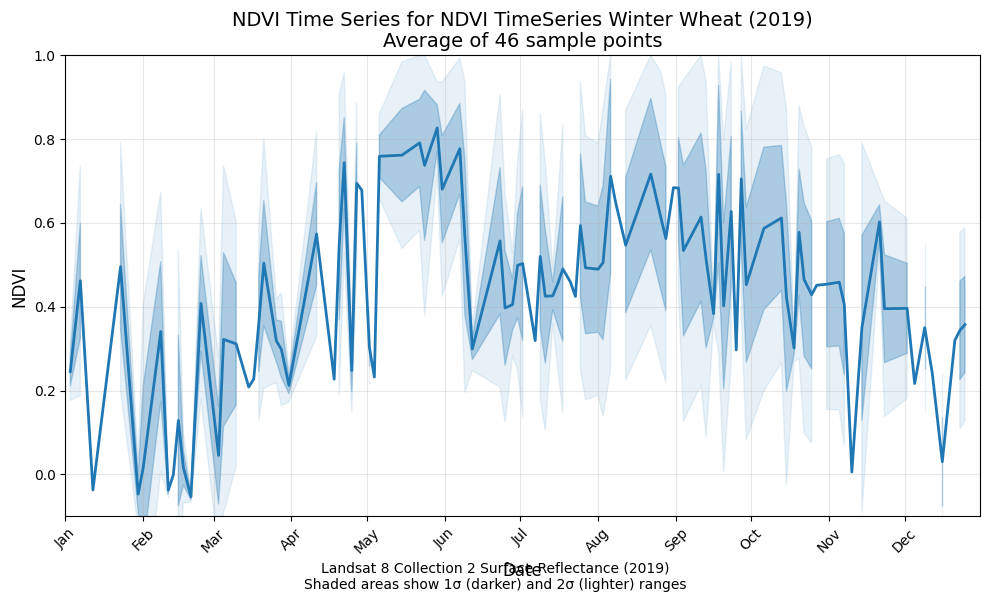

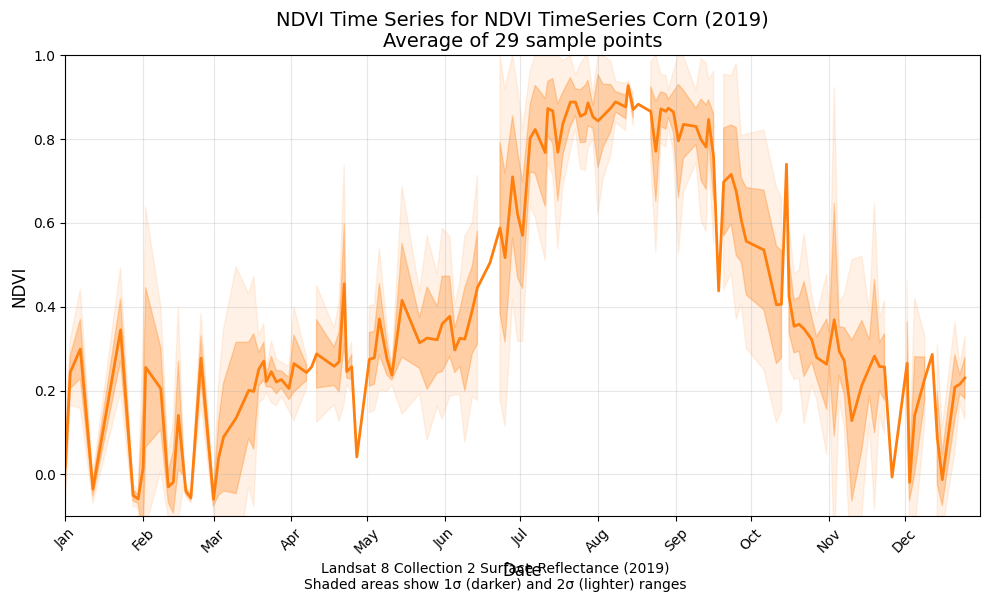

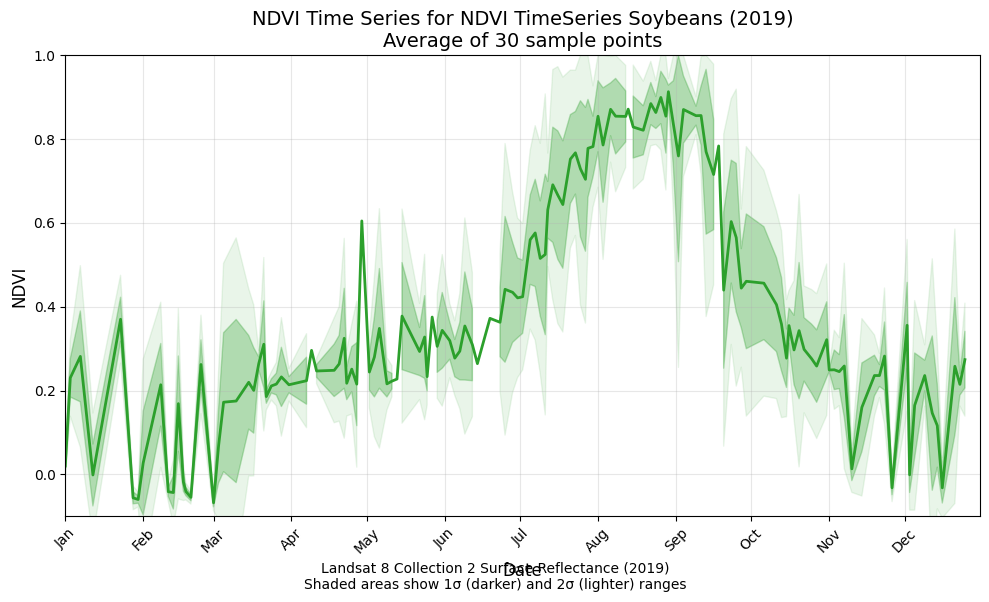

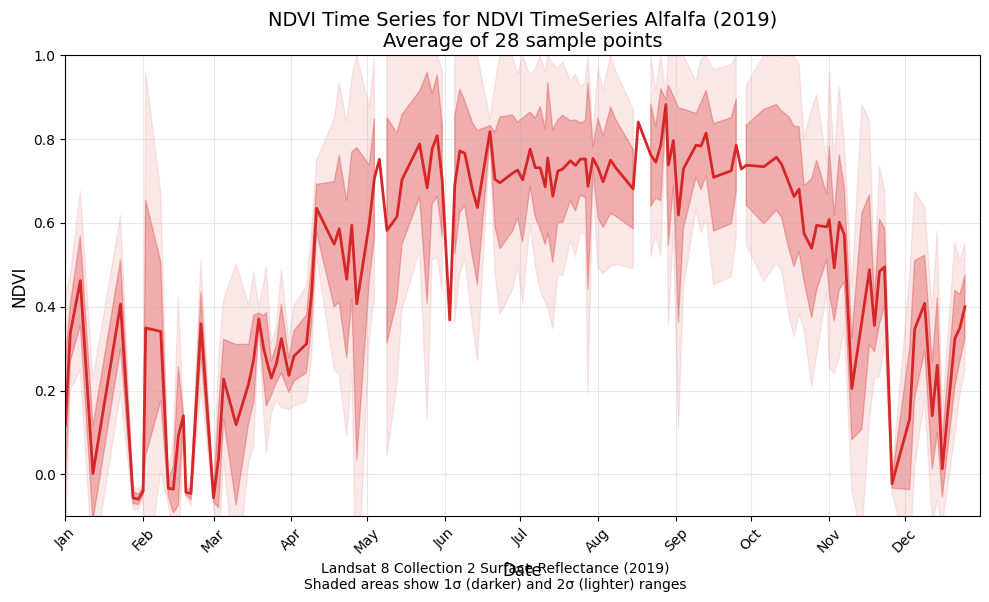

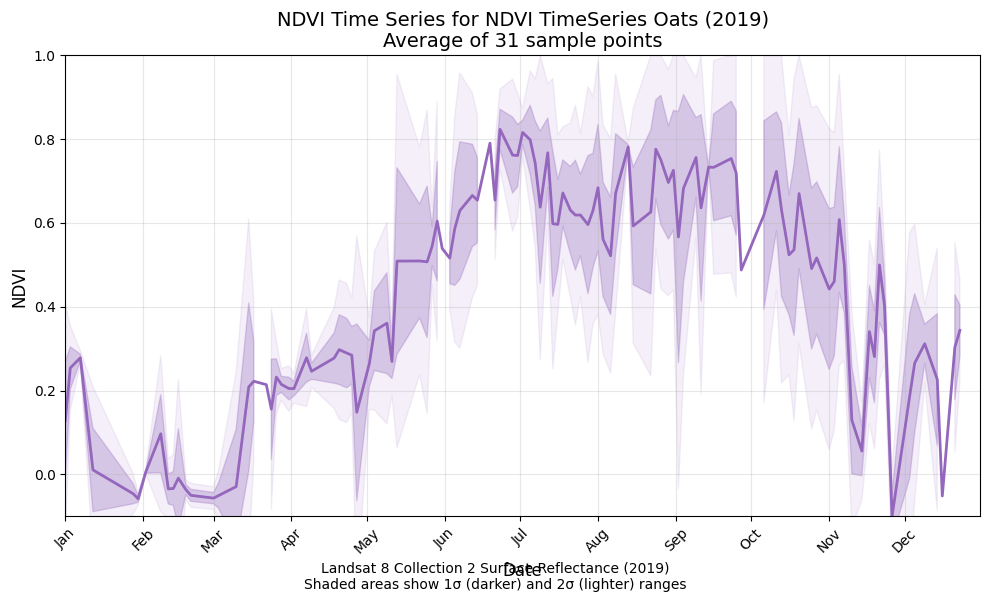

In [ ]:
if len(all_stats) > 0:
    combined_stats = pd.concat(all_stats)
    for crop_name in combined_stats['crop_name'].unique():
        plt.figure(figsize=(10, 6))

        # Filter for this crop
        crop_data = combined_stats[combined_stats['crop_name'] == crop_name]
        color = crop_data['color'].iloc[0]

        # Plot mean and confidence intervals
        plt.plot(crop_data['date'], crop_data['mean'], color=color, linewidth=2)
        plt.fill_between(crop_data['date'], crop_data['lower_1sigma'], crop_data['upper_1sigma'],
                         color=color, alpha=0.3)
        plt.fill_between(crop_data['date'], crop_data['lower_2sigma'], crop_data['upper_2sigma'],
                         color=color, alpha=0.1)

        mean_count = crop_data['count'].mean()

        plt.xlabel('Date', fontsize=12)
        plt.ylabel('NDVI', fontsize=12)
        plt.title(f'NDVI Time Series for {crop_name} (2019)\nAverage of {mean_count:.0f} sample points', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2019-12-31'))
        plt.ylim(-0.1, 1.0)

        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
        plt.xticks(rotation=45)

        plt.figtext(0.5, 0.01,
                    "Landsat 8 Collection 2 Surface Reflectance (2019)\n"
                    "Shaded areas show 1σ (darker) and 2σ (lighter) ranges",
                    ha='center', fontsize=10)

        plt.tight_layout()
        plt.show()

The graphs look good!

### Task 2.3: Additional Analysis (optional but recommended)

Perform any additional analysis on the crops that you find interesting or useful for modeling. This is an open-ended exploration task to dive deeper into the data. Document your methodology and insights gained from any additional analysis. Visualizations and quantitative metrics are highly encouraged. This is your opportunity to freely explore the data and extract patterns that could help with crop modeling in Task 3. Be creative and have fun with the analysis!

*Any additional analysis that provides unique insights or utility for crop modeling may receive extra credit.* The depth and uniqueness of the exploration will determine the amount of extra credit awarded.

Some examples of analysis that could warrant extra credit:
- Extracting crop rotational patterns across multiple years
- Quantifying optimal temporal windows for distinguishing between crops (e.g. dormancy, emergence, harvest)
- Analyzing the utility of additional indices on top of NDVI
- Incorporating time series from sensors across the Landsat mission (e.g. L5/L7/L8/L9)

For the additional analysis, I decided to use a method I learned in a previous class called Dynamic Mode Decompositon.

I've used it before previously in a fluid flow context where it was able to pick up the temporal modes of fluid flow and reconstruct a picture of the fluid flow.

Although it isn't the exact same context, I thought it might be effective here because similar to the fluid flow scenario, where we are using time series data to break down the non linear fluid dynamics into dominant modes, in this scenario, we can use time series data to break down and characterize the non-linear crop growth dynamics into dominant patterns as well.

The idea is that if we do this, we can, in a way, single out the effects of the biological processes behind the crops in the form of modes. Then we can input this into our model as a feature to help classify crops.

It makes sense in my head but lets see how it actually performs.

This function takes an roi and the years from 2015 to 2018 and redoes the sampling process for each year then generates the NDVI time series for each year into google drive like before.

In [ ]:
def generate_previous_cdl_images(roi, name, years=[2015, 2016, 2017, 2018]):
    cdl_images = {year: ee.Image(f'USDA/NASS/CDL/{year}').select('cropland')
                  .reproject('EPSG:5070', None, 30)
                  .clip(roi) for year in years}

    num_samples = 250
    all_samples = {}

    for year in years:
        sampled_points = []
        for code in top_5_crop_codes:
            crop_name = crop_names.get(code, f"Crop {code}")
            sampled_fc = sample_crop_pixels(code, num_samples, crop_name, cdl_images[year], roi)
            sampled_points.append(sampled_fc)
            print(f"Done Sampling for crop code {code} ({crop_name}) in {year}")

        all_samples[year] = ee.FeatureCollection(sampled_points).flatten()

    landsat_collections = {}
    ndvi_collections = {}

    for year in years:
        landsat_collections[year] = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
            .filterDate(f'{year}-01-01', f'{year}-12-31') \
            .filterBounds(roi)

        ndvi_collections[year] = landsat_collections[year].map(process_landsat_image)

    # Process each crop for each year
    for year in years:
        print(f"Processing year {year}")
        samples = all_samples[year]
        collection = ndvi_collections[year]
        folder_path = f'NDVI_TimeSeries_{year}_{name}'

        for i, code in enumerate(top_5_crop_codes):
            crop_name = crop_names.get(code, f"Crop {code}")
            print(f"  Processing crop {i+1}/5: {crop_name} (code: {code})")

            crop_time_series = extract_crop_ndvi_time_series(code, crop_name, collection, samples)

            task = ee.batch.Export.table.toDrive(
                collection=crop_time_series,
                description=f'NDVI_TimeSeries_{crop_name.replace(" ", "_")}',
                folder=folder_path,
                fileFormat='CSV'
            )
            task.start()

            print(f"Started export task for {crop_name} in {folder_path}")

        print(f"Finished processing all crops for year {year}")

    print("All NDVI time series extraction tasks started!")

We run the function over Iowa and Illinois over 2015, 2016, 2017, and 2018.

In [ ]:
target_roi = roi_illinois.union(roi_iowa)
generate_previous_cdl_images(target_roi, 'combined', years=[2015, 2016, 2017, 2018])

Done Sampling for crop code 1 (Corn) in 2015
Done Sampling for crop code 5 (Soybeans) in 2015
Done Sampling for crop code 36 (Alfalfa) in 2015
Done Sampling for crop code 24 (Winter Wheat) in 2015
Done Sampling for crop code 28 (Oats) in 2015
Done Sampling for crop code 1 (Corn) in 2016
Done Sampling for crop code 5 (Soybeans) in 2016
Done Sampling for crop code 36 (Alfalfa) in 2016
Done Sampling for crop code 24 (Winter Wheat) in 2016
Done Sampling for crop code 28 (Oats) in 2016
Done Sampling for crop code 1 (Corn) in 2017
Done Sampling for crop code 5 (Soybeans) in 2017
Done Sampling for crop code 36 (Alfalfa) in 2017
Done Sampling for crop code 24 (Winter Wheat) in 2017
Done Sampling for crop code 28 (Oats) in 2017
Done Sampling for crop code 1 (Corn) in 2018
Done Sampling for crop code 5 (Soybeans) in 2018
Done Sampling for crop code 36 (Alfalfa) in 2018
Done Sampling for crop code 24 (Winter Wheat) in 2018
Done Sampling for crop code 28 (Oats) in 2018
Processing year 2015
  Proce

Now, with the NDVI Time series data, we want to actually apply the DMD analysis. The function below:

1. Prepares the data by removing outliers, interpolating to create a uniform time series dataset and normalizes the NDVI to 0-1.
2. Performs the DMD analysis by organizing the data into a matrix with each row representing a crop-year combo before applying DMD using the PyDMD library with 6 modes. Then extracts eigenvalues, modes, and dynamics and calculates the frequencies and periods for each mode.
3. Plots the eigenvalues, visualizes the mode strenghths for each crop across the years, and compares the original NDVI data with the DMD reconstructions.
4. Looks at the MSE for each crop and analyzes the consistency of the crop signatures using coefficients of variation.

I implemented this from scratch before but I'll just use a library because it is easier and probably better anyways.

In [ ]:
!pip install pydmd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 3.3 MB/s eta 0:00:00


In [ ]:
from scipy.interpolate import interp1d
from pydmd import DMD
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from collections import defaultdict

def apply_pydmd_across_years(csv_files_by_year):
    all_years_data = {}
    crop_names_set = set()

    # Initial data preparation - same as before
    for year, csv_files in csv_files_by_year.items():
        print(f"\nProcessing year {year}...")

        doy_values = np.arange(60, 212)

        year_crops_data = {}

        for csv_file in csv_files:
            crop_name = os.path.basename(csv_file).replace('NDVI_TimeSeries_', '').replace('.csv', '').replace('_', ' ')
            print(f"  Processing {crop_name}")

            try:
                df = pd.read_csv(csv_file)
                df['date'] = pd.to_datetime(df['date'])
                df['doy'] = pd.to_numeric(df['doy'])

                df = df[(df['doy'] >= 60) & (df['doy'] <= 212)]

                z_scores = np.abs((df['mean'] - df['mean'].mean()) / df['mean'].std())
                df = df[z_scores < 3]

                grouped = df.groupby('doy')['mean'].mean().reset_index()

                # Interpolation Function
                interp_func = interp1d(grouped['doy'], grouped['mean'],
                                      kind='linear', bounds_error=False,
                                      fill_value='extrapolate')

                # Create uniform time series
                uniform_ndvi = interp_func(doy_values)
                uniform_ndvi = np.clip(uniform_ndvi, 0.0, 1.0)

                year_crops_data[crop_name] = uniform_ndvi
                crop_names_set.add(crop_name)
            except pd.errors.EmptyDataError:
                print(f"  Warning: Empty file for {crop_name}, skipping")
                continue
            except Exception as e:
                print(f"  Error processing {csv_file}: {e}")
                continue

        all_years_data[year] = {
            'crop_data': year_crops_data,
            'doy_values': doy_values
        }

    # Get common crop names
    common_crop_names = list(crop_names_set)

    # Store results for each crop
    crop_dmd_results = {}

    # Process each crop type separately
    for crop_name in common_crop_names:
        print(f"\nApplying DMD for crop: {crop_name}")

        # Gather data for this crop across all years
        crop_years_data = []
        years_with_data = []

        for year, year_data in all_years_data.items():
            if crop_name in year_data['crop_data']:
                crop_years_data.append(year_data['crop_data'][crop_name])
                years_with_data.append(year)

        # Skip if we don't have enough years
        if len(crop_years_data) < 2:
            print(f"  Skipping {crop_name}: not enough years of data (need at least 2)")
            continue

        # Convert to numpy array [years, days]
        X_crop = np.array(crop_years_data)

        # Transpose for DMD [days, years]
        X_crop_for_dmd = X_crop.T

        # Determine appropriate svd_rank based on data
        # For small datasets, use min(n_years-1, 6)
        svd_rank = min(len(years_with_data)-1, 6)

        # Apply DMD
        try:
            dmd = DMD(svd_rank=svd_rank, exact=True, opt=True)
            dmd.fit(X_crop_for_dmd)

            # Get reconstruction
            X_crop_dmd = dmd.reconstructed_data.T

            # Extract DMD attributes
            eigenvalues = dmd.eigs
            modes = dmd.modes
            dynamics = dmd.dynamics

            # Calculate frequencies and periods
            dt = 1.0  # day
            frequencies = np.angle(eigenvalues) / (2*np.pi*dt)
            # Avoid division by zero
            periods = np.zeros_like(frequencies)
            valid_indices = np.abs(frequencies) > 1e-10
            periods[valid_indices] = np.abs(1 / frequencies[valid_indices])

            # Create results DataFrame
            results_df = pd.DataFrame({
                'Mode': range(len(eigenvalues)),
                'Frequency (cycles/year)': frequencies * 365,
                'Period (days)': periods,
                'Growth Rate': np.log(np.abs(eigenvalues)) / dt,
                'Eigenvalue': eigenvalues,
                'Eigenvalue Magnitude': np.abs(eigenvalues)
            })

            # Create crop signatures
            crop_signatures = []
            for i, year in enumerate(years_with_data):
                year_dynamics = {'year': year}
                for mode_idx in range(min(svd_rank, dynamics.shape[0])):
                    if i < dynamics.shape[1]:
                        year_dynamics[f'mode_{mode_idx}'] = np.abs(dynamics[mode_idx, i])
                    else:
                        year_dynamics[f'mode_{mode_idx}'] = 0
                crop_signatures.append(year_dynamics)

            # Calculate consistency across years
            mode_variations = {}
            for mode_idx in range(min(svd_rank, dynamics.shape[0])):
                mode_strengths = [d[f'mode_{mode_idx}'] for d in crop_signatures]
                if np.mean(mode_strengths) > 0:
                    cv = np.std(mode_strengths) / np.mean(mode_strengths)
                else:
                    cv = np.nan
                mode_variations[f'mode_{mode_idx}_cv'] = cv

            # Calculate reconstruction MSE
            crop_mse = []
            for i, year in enumerate(years_with_data):
                original = X_crop[i]
                reconstructed = X_crop_dmd[i]
                mse = np.mean((original - reconstructed)**2)
                crop_mse.append(mse)

            avg_mse = np.mean(crop_mse)
            print(f"  {crop_name}: Average MSE = {avg_mse:.6f}")

            # Calculate average reconstruction across all years
            # This represents the typical seasonal pattern captured by DMD
            avg_reconstruction = np.mean(X_crop_dmd, axis=0)

            # Store results for this crop
            crop_dmd_results[crop_name] = {
                'eigenvalues': eigenvalues,
                'modes': modes,
                'dynamics': dynamics,
                'reconstructed': X_crop_dmd,
                'avg_reconstruction': avg_reconstruction,
                'years_with_data': years_with_data,
                'doy_values': doy_values,
                'original_data': X_crop,
                'results_df': results_df,
                'crop_signatures': crop_signatures,
                'mode_variations': mode_variations,
                'avg_mse': avg_mse,
                'mse_by_year': dict(zip(years_with_data, crop_mse))
            }

        except Exception as e:
            print(f"  Error applying DMD to {crop_name}: {e}")
            continue

    # Visualizations for each crop
    for crop_name, results in crop_dmd_results.items():
        print(f"\nVisualizing results for {crop_name}")

        # Plot eigenvalues
        plt.figure(figsize=(10, 8))
        plt.scatter(results['eigenvalues'].real, results['eigenvalues'].imag, s=100,
                   c=np.arange(len(results['eigenvalues'])), cmap='viridis')

        for i, eig in enumerate(results['eigenvalues']):
            plt.annotate(f'{i}', (eig.real, eig.imag), fontsize=12)

        # Unit circle
        theta = np.linspace(0, 2*np.pi, 100)
        plt.plot(np.cos(theta), np.sin(theta), 'k--', alpha=0.5)

        plt.axhline(y=0, color='k', linestyle='-', alpha=0.2)
        plt.axvline(x=0, color='k', linestyle='-', alpha=0.2)
        plt.xlabel('Real Part', fontsize=12)
        plt.ylabel('Imaginary Part', fontsize=12)
        plt.title(f'{crop_name} - DMD Eigenvalues in Complex Plane', fontsize=14)
        plt.axis('equal')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        # Plot mode strengths across years
        plt.figure(figsize=(12, 8))
        n_modes = min(4, len(results['eigenvalues']))
        periods = results['results_df']['Period (days)'].values

        for mode_idx in range(n_modes):
            plt.subplot(2, 2, mode_idx + 1)

            # Extract years and mode strengths
            years = [d['year'] for d in results['crop_signatures']]
            strengths = [d[f'mode_{mode_idx}'] for d in results['crop_signatures']]

            # Plot this mode's strength across years
            plt.plot(years, strengths, 'o-', linewidth=2)
            plt.title(f'Mode {mode_idx} Strength (Period: {periods[mode_idx]:.1f} days)')
            plt.xlabel('Year')
            plt.ylabel('Mode Strength')
            plt.grid(True, alpha=0.3)

        plt.tight_layout()

        # Original data for all years vs average DMD reconstruction
        plt.figure(figsize=(12, 8))
        years_with_data = results['years_with_data']
        doy_values = results['doy_values']

        # Original data for each year
        for i, year in enumerate(years_with_data):
            original = results['original_data'][i]
            plt.plot(doy_values, original, '-', linewidth=1.5, alpha=0.7,
                    label=f'{year} Original')

        # Average DMD reconstruction
        plt.plot(doy_values, results['avg_reconstruction'], '--', linewidth=3,
                label='Avg DMD Reconstruction', color='red')

        plt.title(f"{crop_name} - All Years with Average DMD Reconstruction", fontsize=14)
        plt.xlabel("Day of Year", fontsize=12)
        plt.ylabel("NDVI", fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.xlim(min(doy_values), max(doy_values))
        plt.ylim(0, 1)
        plt.legend()
        plt.tight_layout()

    plt.show()

    return {
        'by_crop': crop_dmd_results,
        'all_years_data': all_years_data,
        'common_crop_names': common_crop_names
    }

Running this function over 2015-2018.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from glob import glob
import matplotlib.dates as mdates


Processing year 2015...
  Processing Corn
  Processing Soybeans
  Processing Alfalfa
  Processing Winter Wheat
  Processing Oats

Processing year 2016...
  Processing Corn
  Processing Soybeans
  Processing Alfalfa
  Processing Winter Wheat
  Processing Oats

Processing year 2017...
  Processing Corn
  Processing Soybeans
  Processing Alfalfa
  Processing Winter Wheat
  Processing Oats

Processing year 2018...
  Processing Corn
  Processing Soybeans
  Processing Alfalfa
  Processing Winter Wheat
  Processing Oats

Applying DMD for crop: Alfalfa
  Alfalfa: Average MSE = 0.008361+0.000000j

Applying DMD for crop: Soybeans
  Soybeans: Average MSE = 0.002273-0.000000j

Applying DMD for crop: Winter Wheat
  Winter Wheat: Average MSE = 0.003814-0.000000j

Applying DMD for crop: Oats
  Oats: Average MSE = 0.006003-0.000000j

Applying DMD for crop: Corn
  Corn: Average MSE = 0.001711-0.000000j

Visualizing results for Alfalfa

Visualizing results for Soybeans

Visualizing results for Winter W

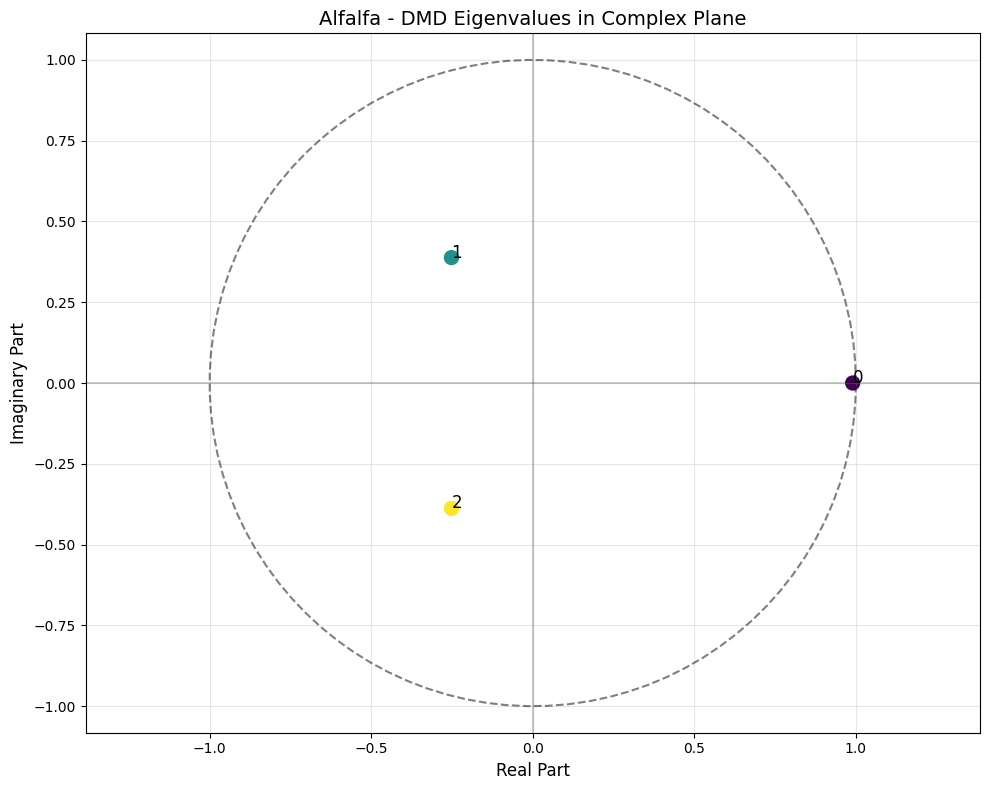

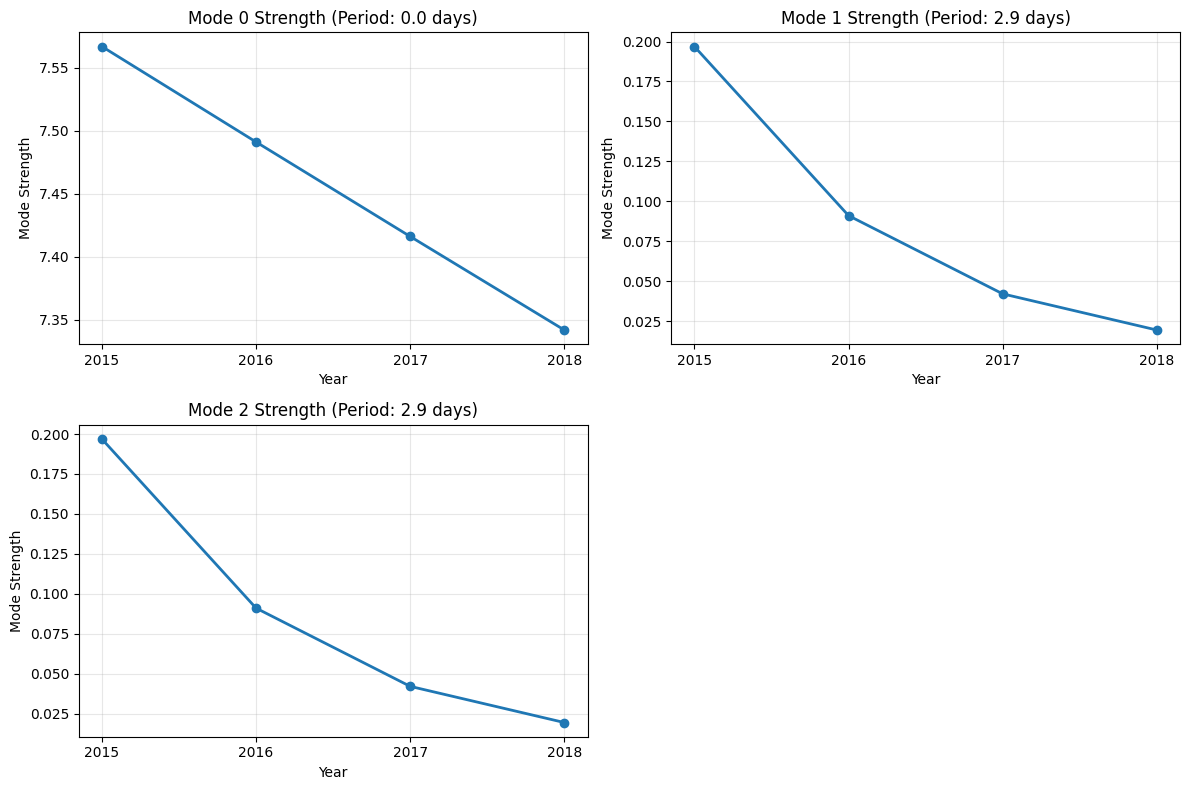

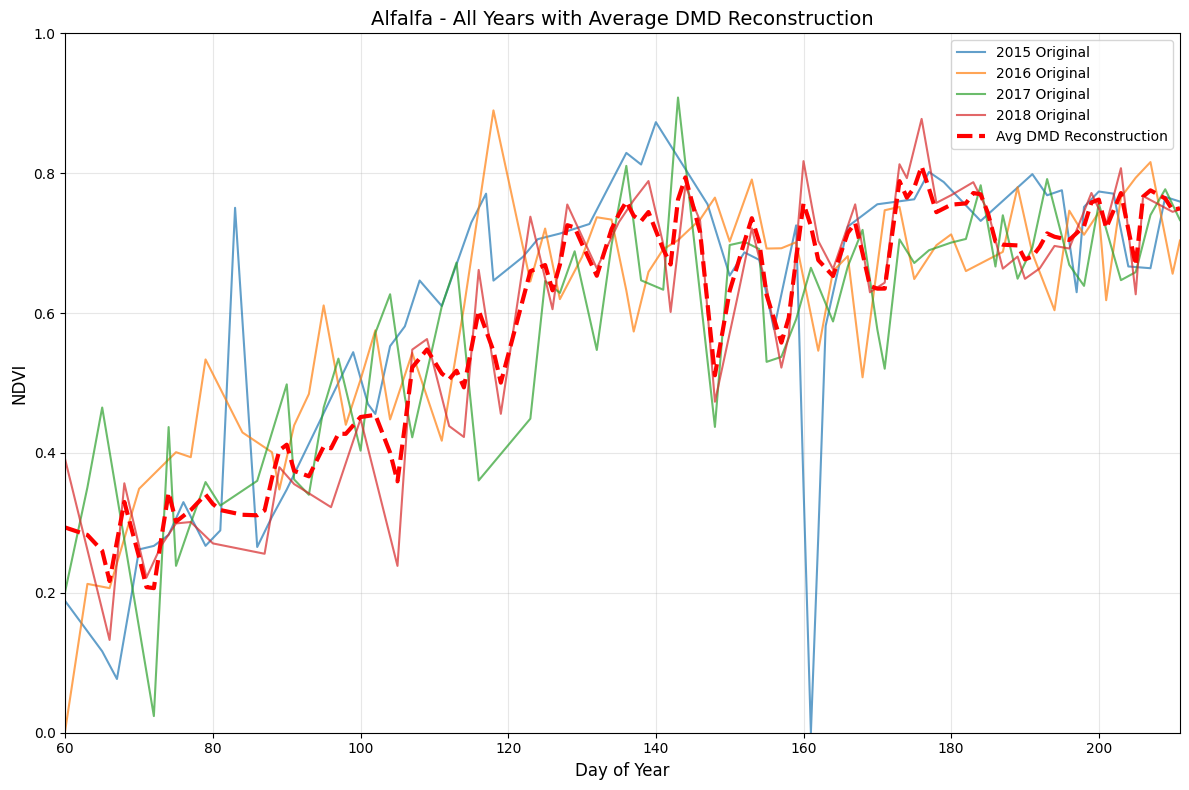

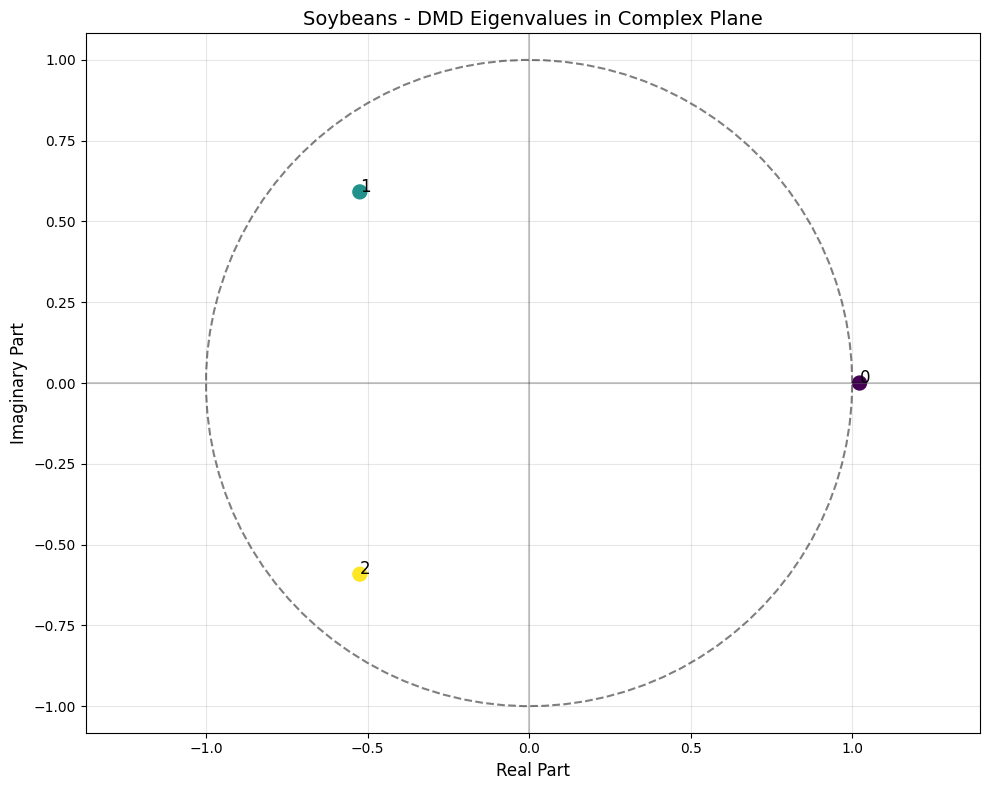

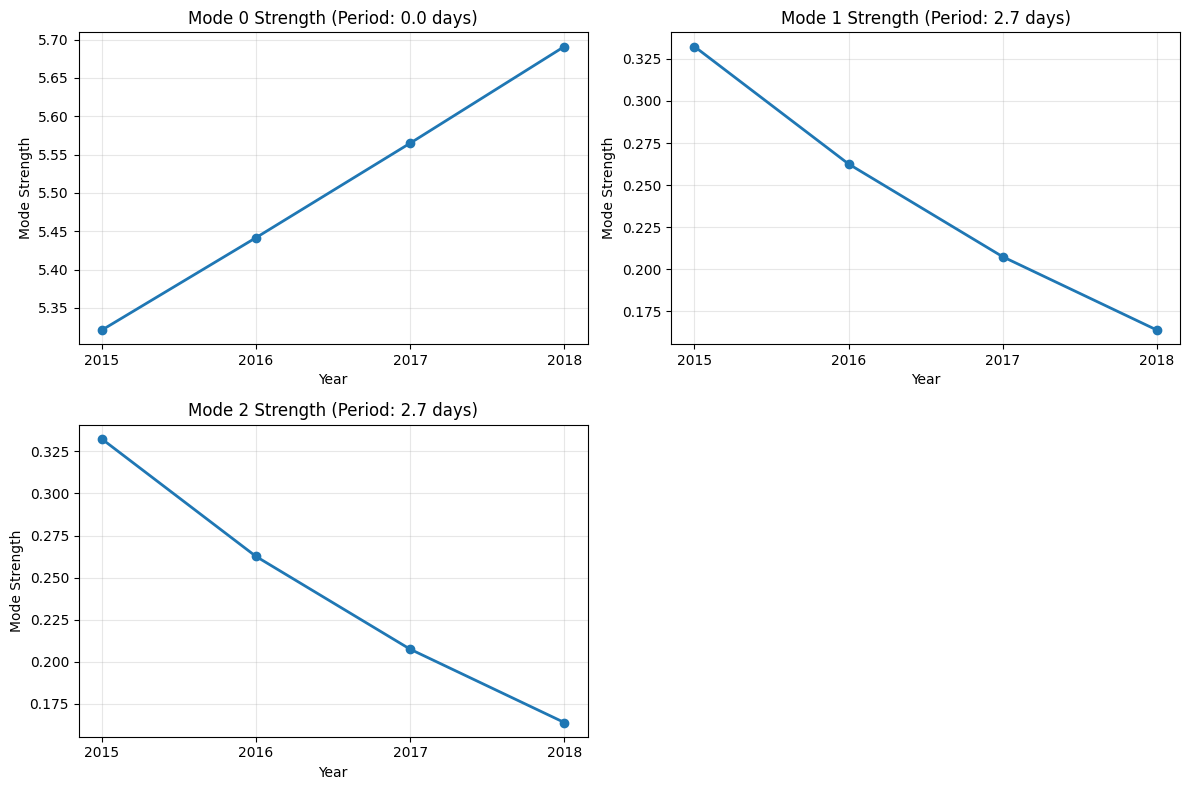

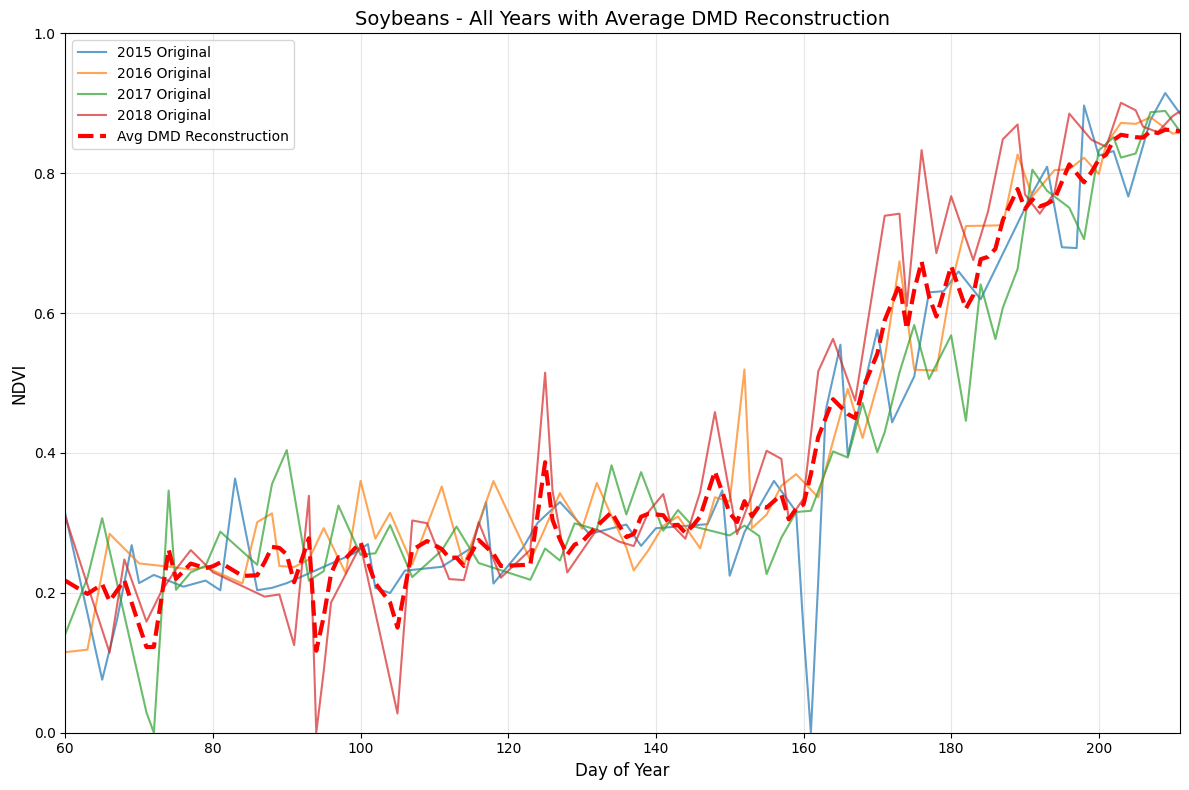

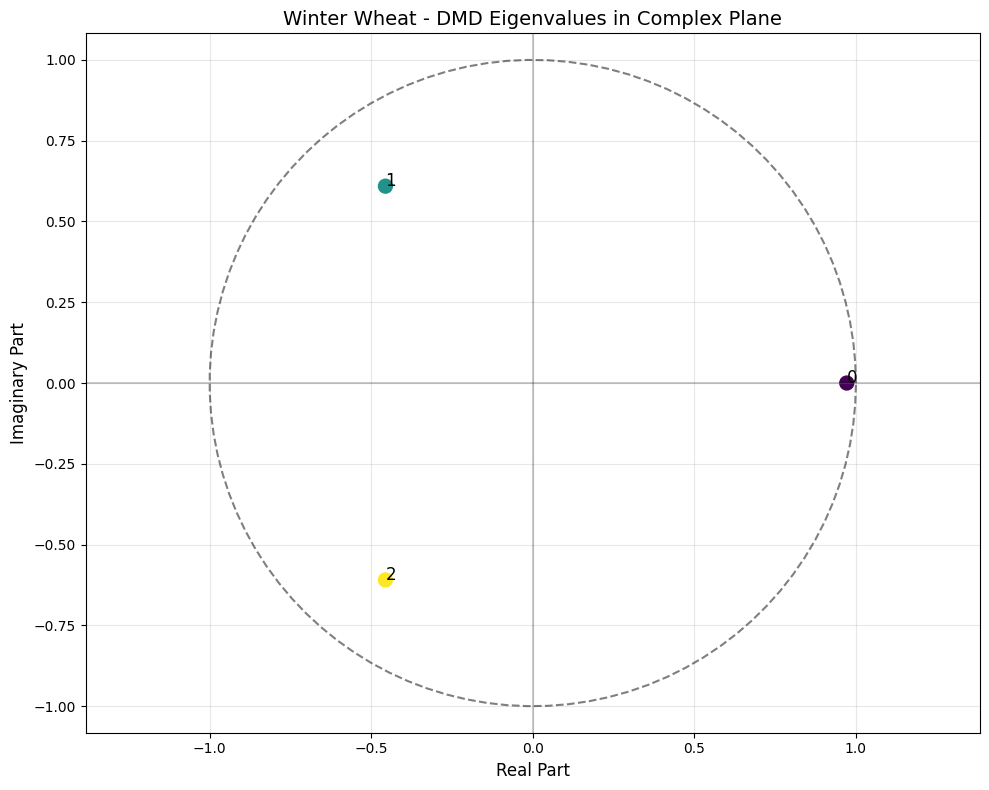

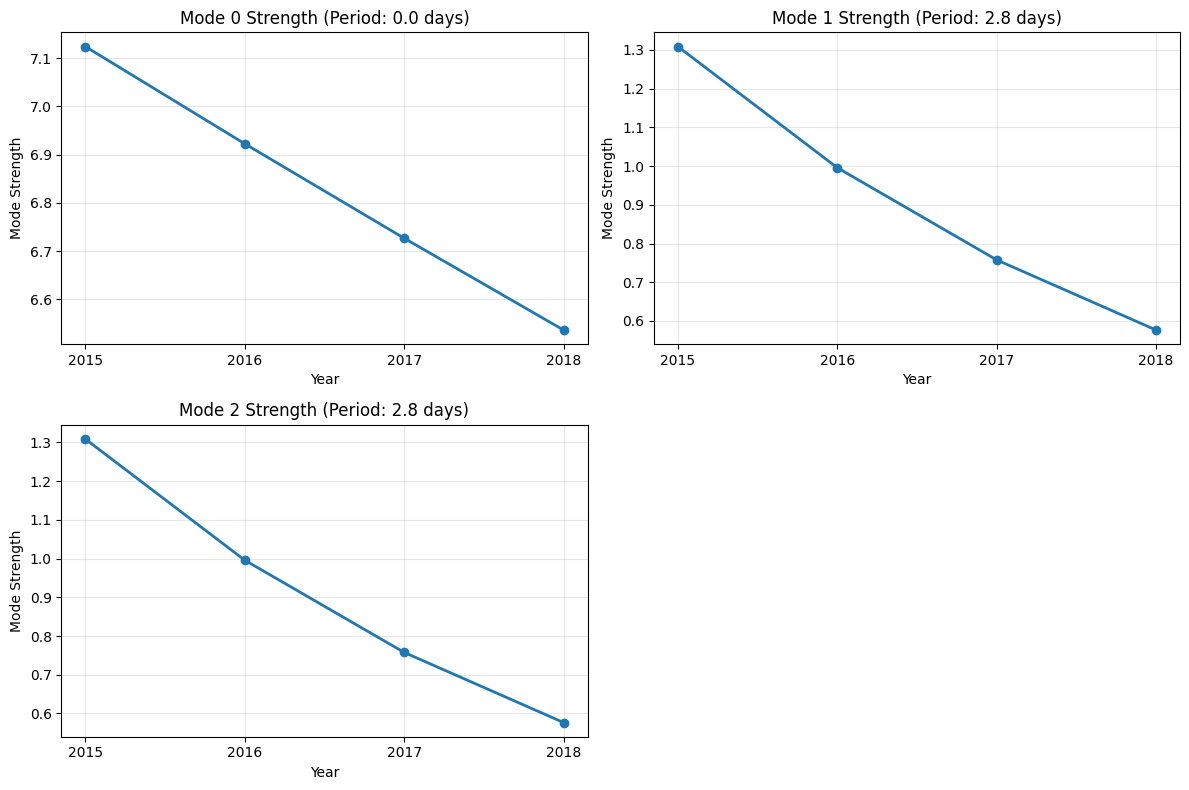

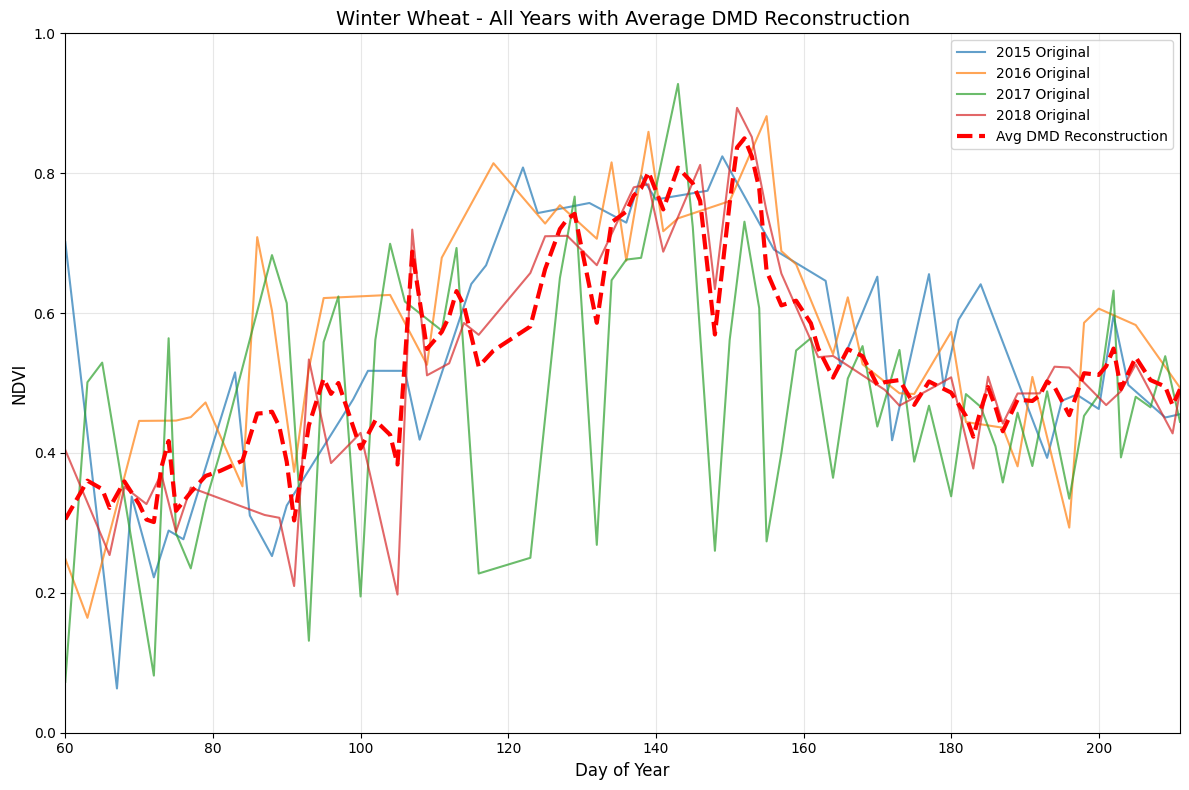

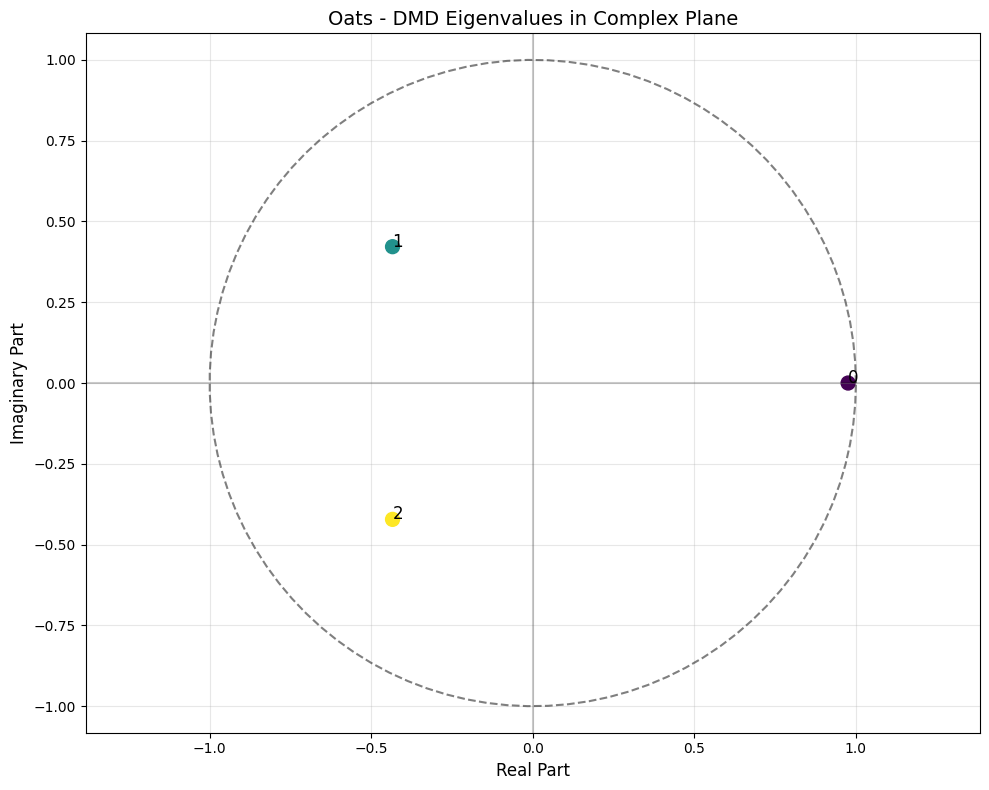

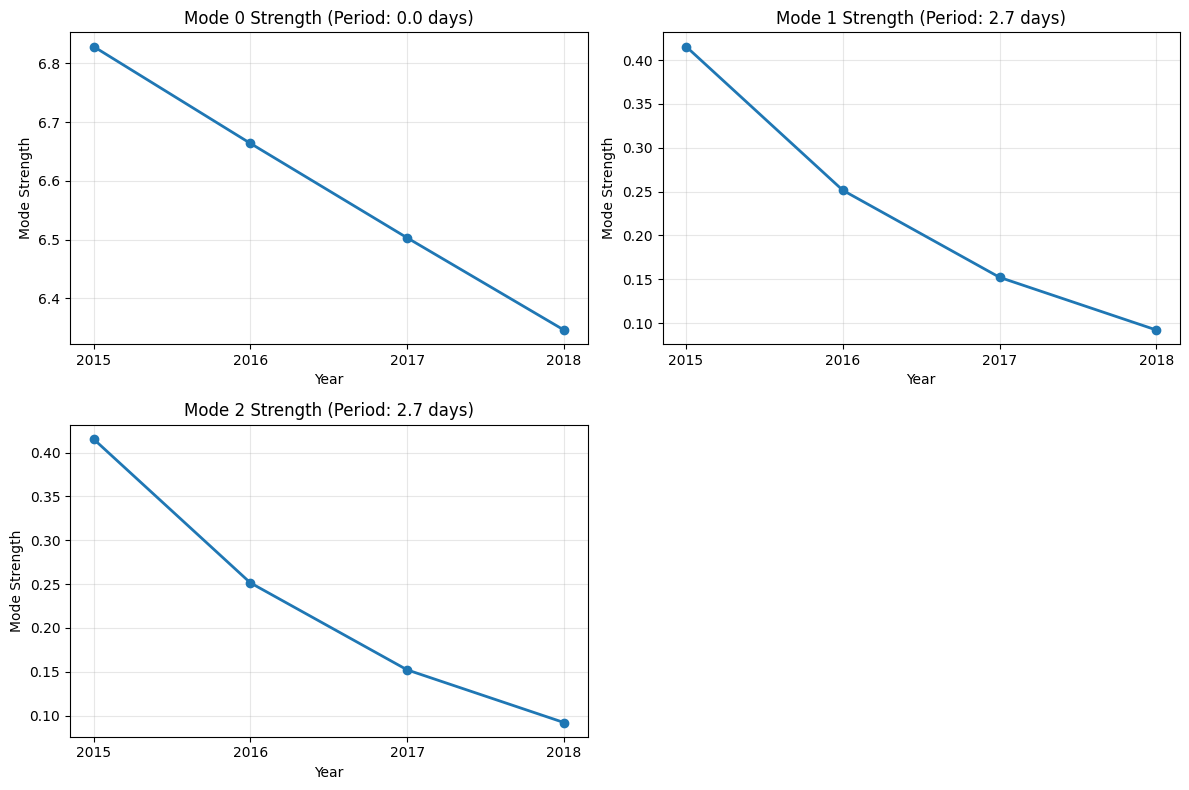

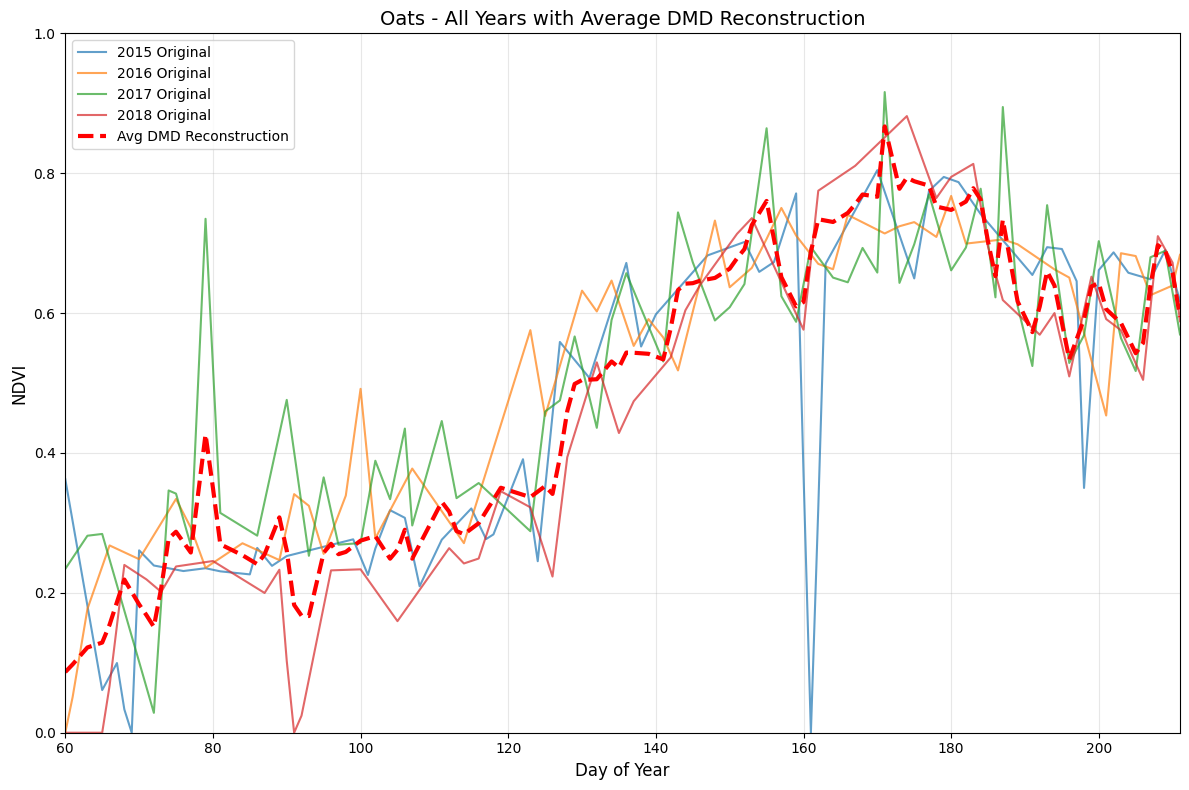

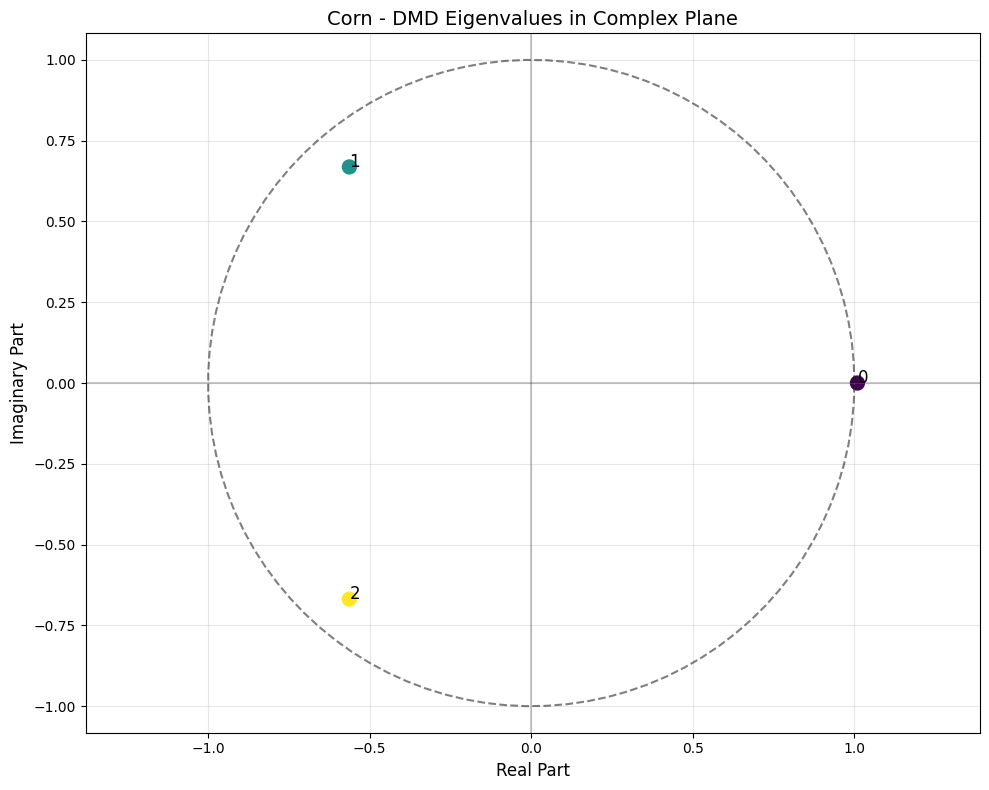

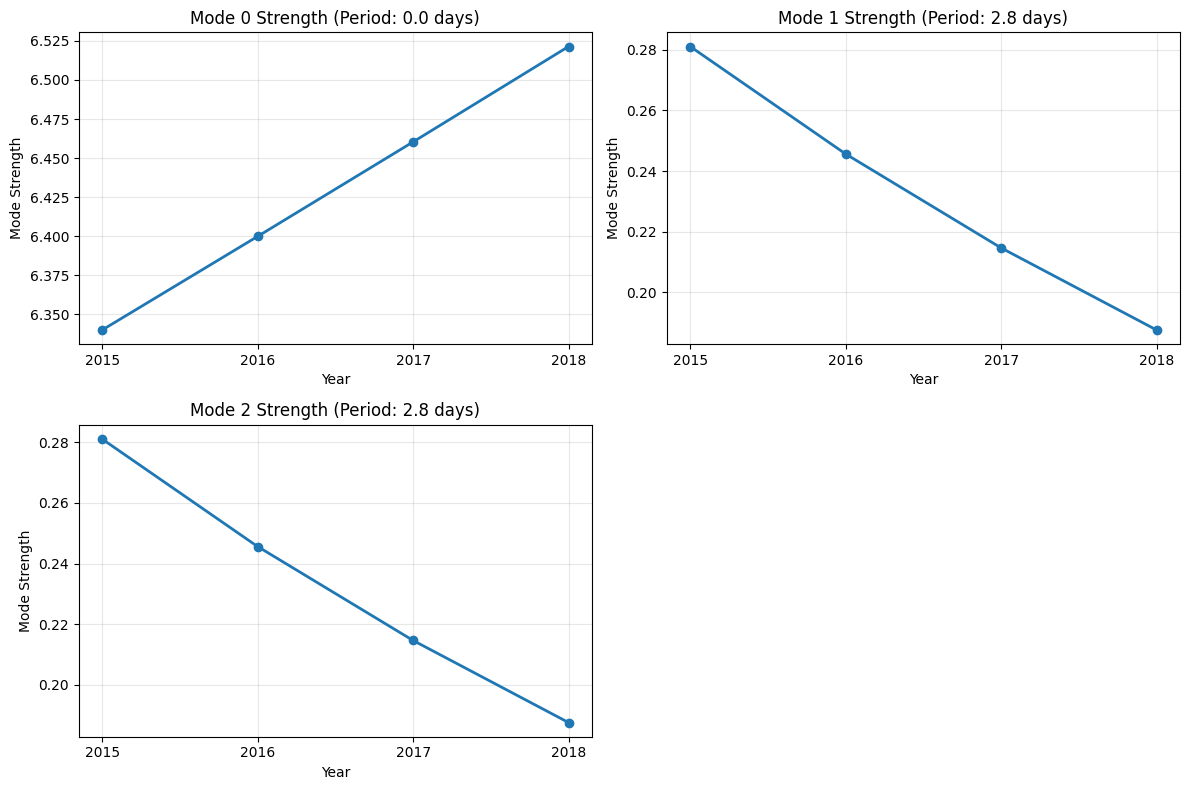

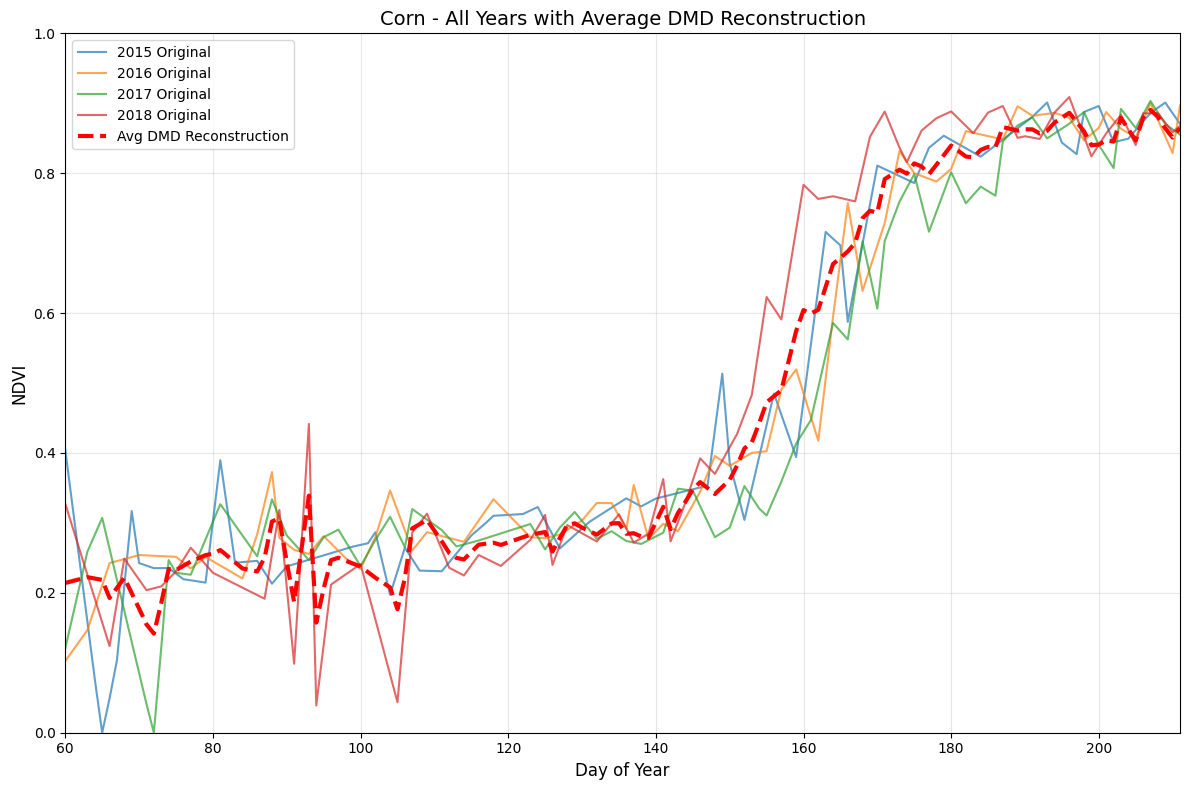


DMD Mode Summary by Crop:

Alfalfa:
 Mode  Period (days)  Frequency (cycles/year)  Eigenvalue Magnitude
    0       0.000000                 0.000000              0.989995
    1       2.927894               124.662971              0.462543
    2       2.927894              -124.662971              0.462543
------------------------------------------------------------

Soybeans:
 Mode  Period (days)  Frequency (cycles/year)  Eigenvalue Magnitude
    0       0.000000                 0.000000              1.022645
    1       2.737165               133.349662              0.790037
    2       2.737165              -133.349662              0.790037
------------------------------------------------------------

Winter Wheat:
 Mode  Period (days)  Frequency (cycles/year)  Eigenvalue Magnitude
    0       0.000000                 0.000000              0.971715
    1       2.838982               128.567208              0.760879
    2       2.838982              -128.567208              0.760879

In [ ]:
csv_files_by_year = {
    '2015': glob(os.path.join('/content/drive/MyDrive/NDVI_TimeSeries_2015_combined', '*.csv')),
    '2016': glob(os.path.join('/content/drive/MyDrive/NDVI_TimeSeries_2016_combined', '*.csv')),
    '2017': glob(os.path.join('/content/drive/MyDrive/NDVI_TimeSeries_2017_combined', '*.csv')),
    '2018': glob(os.path.join('/content/drive/MyDrive/NDVI_TimeSeries_2018_combined', '*.csv'))
}

# Run
results_multi_year = apply_pydmd_across_years(csv_files_by_year)

print("\nDMD Mode Summary by Crop:")
for crop_name, crop_results in results_multi_year['by_crop'].items():
    print(f"\n{crop_name}:")
    print(crop_results['results_df'][['Mode', 'Period (days)', 'Frequency (cycles/year)', 'Eigenvalue Magnitude']].to_string(index=False))
    print("-" * 60)

print("\nCrop Signature Consistency (Coefficient of Variation):")
for crop_name, crop_results in results_multi_year['by_crop'].items():
    print(f"{crop_name}:")
    for mode, cv in crop_results['mode_variations'].items():
        print(f"  {mode}: {cv:.3f}")

Each crop definitely has a specific NDVI pattern over the course of a year that repeats similarly through 2015-2018.

The reconstruction seems to do pretty well as well so those are good signs.

To make this even better, I can probably apply this to other spectral indices like EVI as well.

There seems to be missing data in certain time periods possibly due to clouds or other interferences. Interpolation doesn't work too well in those cases.

## Task 3: Crop Identification Modeling

Goal: Develop and validate a crop classification model using satellite imagery as input.

Overview:

1. Use the sampling script from Task 2 to generate training data for developing a classification model.
2. The model should predict the 5 major crops identified in Task 1, plus a 6th "other" class.
3. The input features should include data (raw and/or derived) from Landsat surface reflectance imagery.
5. Validate model performance by calculating precision, recall, F1 score metrics on a held-out test set.
6. Apply the model to full counties in Iowa and Illinois to create crop classification maps.
7. Visually compare the model output maps to the Cropland Data Layer for analysis.

### Task 3.1: Model Development

Develop a classification model to predict crop type using satellite imagery and temporal vegetation data as input features. The model should be trained on the sampled points from Task 2 and output predictions for the 5 major crops plus a "other" class.

Key Requirements:

- Use sampled crop points (or sampling script) from Task 2 as training data.
- You may want to include more samples for the model than what was created in Task 2.
- Input features must include, but are not limited to, Landsat surface reflectance imagery from the growing season.
- Incorporate temporal vegetation indices like NDVI time series.
- Output predictions for the 5 major crops identified in Task 1 plus an "other" class. This "other" class could be expanded into multiple classes if deemed useful.
- Document modeling methodology including:
  - Model type, input features, training approach
  - Any data preprocessing/augmentation
  - Tools and libraries used
  - Modeling can be fully in GEE or combine external tools like Scikit-learn, Tensorflow, etc.

Remember that ideally, we are attempting to build a model that does NOT require data across the entire year. Put another way, the less data our model needs about the growing season to make a good prediction about the crop type, the better!

If this proves challenging, start by using an entire year's worth of data for your model (like CDL). Achieving good performance with your classifier with a full year's worth of data will earn you full credit, and extra credit will be given to in-season prediction.

We add another class called other (0) to group the non-target crops together.

We also resample more pixel for each class (1250).

We merge them together and call it all_samples and export them

In [ ]:
# Redefining Stuff so to fit new class
# Create a mask for "Other" class
top_crop_mask = ee.Image(0)
for code in top_5_crop_codes:
    top_crop_mask = top_crop_mask.max(cdl_2019.eq(code))

# Then use the mask to identify "Other" areas
other_mask = top_crop_mask.eq(0)
cdl_with_other = cdl_2019.multiply(top_crop_mask).add(other_mask.multiply(0))

crop_classes = {
    1: 'Corn',
    5: 'Soybeans',
    24: 'Winter Wheat',
    28: 'Oats',
    36: 'Alfalfa',
    0: 'Other'
}

corn_samples = sample_crop_pixels(1, 1250, 'Corn', cdl_with_other, combined_roi)
soybean_samples = sample_crop_pixels(5, 1250, 'Soybeans', cdl_with_other, combined_roi)
winter_wheat_samples = sample_crop_pixels(24, 1250, 'Winter Wheat', cdl_with_other, combined_roi)
oats_samples = sample_crop_pixels(28, 1250, 'Oats', cdl_with_other, combined_roi)
alfalfa_samples = sample_crop_pixels(36, 1250, 'Alfalfa', cdl_with_other, combined_roi)
other_samples = sample_crop_pixels(0, 1250, 'Other', cdl_with_other, combined_roi)

all_samples = corn_samples \
    .merge(soybean_samples) \
    .merge(winter_wheat_samples) \
    .merge(oats_samples) \
    .merge(alfalfa_samples) \
    .merge(other_samples)

# Exporting all samples
export_task = ee.batch.Export.table.toDrive(
    collection=all_samples,
    description='crop_samples_all_classes',
    folder='training_crop_samples',
    fileFormat='CSV'
)
export_task.start()
print("Started export task for all crop samples")

# Exporting each crop individually
for code, name in crop_classes.items():
    class_samples = all_samples.filter(ee.Filter.eq('crop_code', code))
    export_task = ee.batch.Export.table.toDrive(
        collection=class_samples,
        description=f'crop_samples_{name.replace(" ", "_")}',
        folder='training_crop_samples',
        fileFormat='CSV'
    )
    export_task.start()
    print(f"Started export task for {name} samples")


Started export task for all crop samples
Started export task for Corn samples
Started export task for Soybeans samples
Started export task for Winter Wheat samples
Started export task for Oats samples
Started export task for Alfalfa samples
Started export task for Other samples


Mapping to visually confirm the sampling.

In [ ]:
import matplotlib.colors as mcolors

m = geemap.Map()
m.centerObject(combined_roi, 8)
m.addLayer(combined_roi, {}, 'ROI Boundary', opacity=0.5)

crop_colors = {
    1: 'yellow',      # Corn
    5: 'green',       # Soybeans
    24: 'brown',      # Winter Wheat
    28: 'orange',     # Oats
    36: 'purple',     # Alfalfa
    0: 'gray'         # Other
}

m.addLayer(corn_samples, {'color': crop_colors[1], 'pointSize': 3}, 'Corn Samples')
m.addLayer(soybean_samples, {'color': crop_colors[5], 'pointSize': 3}, 'Soybeans Samples')
m.addLayer(winter_wheat_samples, {'color': crop_colors[24], 'pointSize': 3}, 'Winter Wheat Samples')
m.addLayer(oats_samples, {'color': crop_colors[28], 'pointSize': 3}, 'Oats Samples')
m.addLayer(alfalfa_samples, {'color': crop_colors[36], 'pointSize': 3}, 'Alfalfa Samples')
m.addLayer(other_samples, {'color': crop_colors[0], 'pointSize': 3}, 'Other Samples')

legend_dict = {}
for code, name in crop_classes.items():
    color_name = crop_colors[code]
    rgb = tuple(int(255 * x) for x in mcolors.to_rgb(color_name))
    legend_dict[name] = rgb

m.add_legend(title="Crop Samples", legend_dict=legend_dict)

cdl_vis = {
    'min': 0,
    'max': 36,
    'palette': ['gray', 'yellow', 'green', 'brown', 'orange', 'purple']
}
m.addLayer(cdl_with_other, cdl_vis, 'CDL with Other Class', opacity=0.7, shown=False)

m

Map(center=[41.093730215537185, -91.25861020694991], controls=(WidgetControl(options=['position', 'transparent…

Looks good.

To mask clouds and shadows, we take advantage of the QA_PIXEL band while adding scaled surface reflectance bands + related spectral indices. I use NDVI, EVI, and the DOY here.

In [ ]:
def mask_l8_clouds(image):
    # Get the QA_PIXEL band for cloud masking
    qa = image.select('QA_PIXEL')

    # Masking for clouds, shadows, and clear pixels
    cloud_bit = 1 << 3
    cloud_shadow_bit = 1 << 4
    clear_bit = 1 << 6

    cloud_mask = qa.bitwiseAnd(cloud_bit).eq(0)
    cloud_shadow_mask = qa.bitwiseAnd(cloud_shadow_bit).eq(0)
    clear_mask = qa.bitwiseAnd(clear_bit).neq(0)

    mask = cloud_mask.And(cloud_shadow_mask).And(clear_mask)

    return image.updateMask(mask)

def add_indices(image):
    # Scale the surface reflectance bands
    optical_bands = image.select(['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7'])
    scaled = optical_bands.multiply(0.0000275).add(-0.2)

    # Get individual bands
    blue = scaled.select('SR_B2')
    green = scaled.select('SR_B3')
    red = scaled.select('SR_B4')
    nir = scaled.select('SR_B5')
    swir1 = scaled.select('SR_B6')
    swir2 = scaled.select('SR_B7')

    # Calculate indices
    # NDVI - general vegetation health
    ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')

    # EVI - enhanced vegetation index (reduces soil and atmospheric effects)
    evi = nir.subtract(red).multiply(2.5) \
        .divide(nir.add(red.multiply(6)).subtract(blue.multiply(7.5)).add(1)) \
        .rename('EVI')

    # Add day of year for temporal reference
    doy = ee.Image(image.date().getRelative('day', 'year')).rename('DOY').toUint16()

    return image.addBands([ndvi, evi, doy])

We focus on March through July to try and predict the data earlier on in the year.

In [ ]:
# Get Landsat imagery for early-to-mid growing season
# Focusing on March through July for early prediction
early_mid_season = {
    'start': '2019-03-01',
    'end': '2019-07-31'
}

landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterDate(early_mid_season['start'], early_mid_season['end']) \
    .filterBounds(combined_roi) \
    .map(mask_l8_clouds) \
    .map(add_indices)

print(f"Number of Landsat images: {landsat.size().getInfo()}")

Number of Landsat images: 229


We create temporal composites month by month for 2019 to try and capture the phenological behavior.

The function create_monthy_features calculates the mean, median, and standard deviaton per month for ndvi, evi, and doy.

In [ ]:
# Function to create monthly features (optimized version)
def create_monthly_features(collection, month_name):
    if collection.size().getInfo() == 0:
        print(f'No images for {month_name}')
        return None

    bands_for_all_stats = ['EVI', 'DOY', 'NDVI']

    median_full = collection.select(bands_for_all_stats).median()
    mean_full = collection.select(bands_for_all_stats).mean()
    std_dev_full = collection.select(bands_for_all_stats).reduce(ee.Reducer.stdDev())

    # Renaming bands
    median_full = median_full.rename(median_full.bandNames().map(lambda name:
        ee.String(month_name).cat('_median_').cat(name)))
    mean_full = mean_full.rename(mean_full.bandNames().map(lambda name:
        ee.String(month_name).cat('_mean_').cat(name)))
    std_dev_full = std_dev_full.rename(std_dev_full.bandNames().map(lambda name:
        ee.String(month_name).cat('_stdDev_').cat(name)))

    return ee.Image.cat([median_full, mean_full, std_dev_full])

This part gets a little tricky, I originally had the DMD analysis include spatial dependence using the early months of the 2019 CDL data. This made the model perform extremely well for the test data (about 91% overall accuracy) but when I extended it to Crawford county or Grant, the performance was really bad.

To try and make the model more robust and not overfit the training region, I removed the spatial dependence.

So I took the DMD results and computed, for each month, the 4 year average NDVI and the mean and median strength for each mode.

This took an excrutiatingly long amount of time to debug (the reason I submitted it late) because I the features we trained with and the features we deploy on have to be the exact same. The issue is that there is missing data in both the training region and the deploy region. So there were some features that were in the training region that weren't in the deploy region, vice versa.

I ran the code without the DMD way before and it worked and the issue would be solved if I didn't use DMD as features but I had already put too much effort into to it just erase it...

In [ ]:
def add_dmd_features_to_classifier(all_features, dmd_results, top_5_crop_codes, crop_legend, training_features=None):

    # If no training_features provided, run in "training mode" to collect features
    is_training = training_features is None

    if is_training:
        print("Running in training mode to collect feature names")
        created_features = []
    else:
        print(f"Running in deployment mode with {len(training_features)} expected features")

    months = ['march', 'april', 'may', 'june', 'july']
    month_doy_ranges = {
        'march': (60, 90),
        'april': (91, 120),
        'may': (121, 151),
        'june': (152, 181),
        'july': (182, 212)
    }

    # Create DMD features
    dmd_bands = []

    # First collect all values for normalization
    all_ndvi_values = []
    all_mode_strengths = {i: [] for i in range(6)}

    # Collect values for normalization
    for crop_code in top_5_crop_codes:
        crop_name = crop_legend.get(crop_code, f"crop_{crop_code}")

        if crop_name in dmd_results['by_crop']:
            crop_results = dmd_results['by_crop'][crop_name]
            avg_reconstruction = crop_results['avg_reconstruction']
            doy_values = crop_results['doy_values']
            dynamics = crop_results['dynamics']
            num_modes = min(6, dynamics.shape[0])

            # Collect NDVI values (with empty month check)
            for month in months:
                month_start, month_end = month_doy_ranges[month]
                month_indices = [i for i, doy in enumerate(doy_values) if month_start <= doy <= month_end]

                if month_indices:
                    month_ndvi = np.mean(avg_reconstruction[month_indices])
                    all_ndvi_values.append(month_ndvi)

            # Collect mode strengths
            for mode_idx in range(num_modes):
                mode_strengths = np.abs(dynamics[mode_idx, :])
                all_mode_strengths[mode_idx].extend(mode_strengths)

    # Calculate min/max for normalization
    ndvi_min = min(all_ndvi_values) if all_ndvi_values else 0
    ndvi_max = max(all_ndvi_values) if all_ndvi_values else 1
    ndvi_range = ndvi_max - ndvi_min if ndvi_max > ndvi_min else 1

    mode_mins = {i: min(vals) if vals else 0 for i, vals in all_mode_strengths.items()}
    mode_maxs = {i: max(vals) if vals else 1 for i, vals in all_mode_strengths.items()}
    mode_ranges = {i: mode_maxs[i] - mode_mins[i] if mode_maxs[i] > mode_mins[i] else 1
                   for i in all_mode_strengths.keys()}

    # Creating features only if in training mode or part of training_features
    for crop_code in top_5_crop_codes:
        crop_name = crop_legend.get(crop_code, f"crop_{crop_code}")

        if crop_name in dmd_results['by_crop']:
            crop_results = dmd_results['by_crop'][crop_name]
            avg_reconstruction = crop_results['avg_reconstruction']
            doy_values = crop_results['doy_values']
            dynamics = crop_results['dynamics']
            num_modes = min(6, dynamics.shape[0])

            for month in months:
                feature_name = f'{crop_name}_{month}_avg_ndvi'

                if is_training or feature_name in training_features:
                    month_start, month_end = month_doy_ranges[month]
                    month_indices = [i for i, doy in enumerate(doy_values) if month_start <= doy <= month_end]

                    if month_indices:
                        month_ndvi = np.mean(avg_reconstruction[month_indices])
                        normalized_ndvi = (month_ndvi - ndvi_min) / ndvi_range
                    else:
                        normalized_ndvi = 0.5  # Default for empty month

                    # Create the feature
                    ndvi_band = ee.Image.constant(float(normalized_ndvi)).rename(feature_name)
                    dmd_bands.append(ndvi_band)

                    if is_training:
                        created_features.append(feature_name)

                # Check mode features
                for mode_idx in range(num_modes):
                    # Mean strength feature
                    feature_name = f'{crop_name}_{month}_mode_{mode_idx}_mean_strength'

                    if is_training or feature_name in training_features:
                        mode_strengths = np.abs(dynamics[mode_idx, :])
                        mean_strength = np.mean(mode_strengths)
                        normalized_mean = (mean_strength - mode_mins[mode_idx]) / mode_ranges[mode_idx]

                        strength_band = ee.Image.constant(float(normalized_mean)).rename(feature_name)
                        dmd_bands.append(strength_band)

                        if is_training:
                            created_features.append(feature_name)

                    # Median strength feature
                    feature_name = f'{crop_name}_{month}_mode_{mode_idx}_median_strength'

                    if is_training or feature_name in training_features:
                        mode_strengths = np.abs(dynamics[mode_idx, :])
                        median_strength = np.median(mode_strengths)
                        normalized_median = (median_strength - mode_mins[mode_idx]) / mode_ranges[mode_idx]

                        med_strength_band = ee.Image.constant(float(normalized_median)).rename(feature_name)
                        dmd_bands.append(med_strength_band)

                        if is_training:
                            created_features.append(feature_name)

    # In deployment mode, ensure all training features exist with defaults
    if not is_training:
        missing_features = set(training_features) - set([band.bandNames().getInfo()[0] for band in dmd_bands])

        if missing_features:
            print(f"Adding {len(missing_features)} missing features from training set")
            for feature_name in missing_features:
                default_band = ee.Image.constant(0.5).rename(feature_name)
                dmd_bands.append(default_band)

    # Combine and add DMD features
    try:
        if dmd_bands:
            dmd_features = ee.Image.cat(dmd_bands)
            result = all_features.addBands(dmd_features)

            if is_training:
                print(f"Created {len(created_features)} DMD features in training mode")
                # Return both the results and the feature list in training mode
                return result, created_features
            else:
                print(f"Added {len(dmd_bands)} DMD features in deployment mode")
                return result
        else:
            print("Warning: No DMD bands created")
            if is_training:
                return all_features, []
            else:
                return all_features
    except Exception as e:
        print(f"ERROR: Could not add DMD bands: {e}")
        if is_training:
            return all_features, []
        else:
            return all_features

Adding phenological features like the greenup rate, mid-season growth, and late-season changes.

In [ ]:
def add_phenology_features(all_features):
    # Create phenology features

    # 1. Green-up rate (May-March difference)
    greenup = all_features.select('may_median_NDVI').subtract(all_features.select('march_median_NDVI')).rename('greenup_rate')

    # 2. Mid-season growth (June-May difference)
    mid_growth = all_features.select('june_median_NDVI').subtract(all_features.select('may_median_NDVI')).rename('mid_growth_rate')

    # 3. Late-season changes (July-June difference)
    late_growth = all_features.select('july_median_NDVI').subtract(all_features.select('june_median_NDVI')).rename('late_growth_rate')

    # 4. Maximum NDVI - calculate directly without ImageCollection
    march_ndvi = all_features.select('march_median_NDVI')
    april_ndvi = all_features.select('april_median_NDVI')
    may_ndvi = all_features.select('may_median_NDVI')
    june_ndvi = all_features.select('june_median_NDVI')
    july_ndvi = all_features.select('july_median_NDVI')

    # Calculate max NDVI by taking the maximum at each step
    max_ndvi = march_ndvi
    max_ndvi = max_ndvi.max(april_ndvi)
    max_ndvi = max_ndvi.max(may_ndvi)
    max_ndvi = max_ndvi.max(june_ndvi)
    max_ndvi = max_ndvi.max(july_ndvi)
    max_ndvi = max_ndvi.rename('max_ndvi')

    # 5. NDVI Range - similarly calculate min directly
    min_ndvi = march_ndvi
    min_ndvi = min_ndvi.min(april_ndvi)
    min_ndvi = min_ndvi.min(may_ndvi)
    min_ndvi = min_ndvi.min(june_ndvi)
    min_ndvi = min_ndvi.min(july_ndvi)

    ndvi_range = max_ndvi.subtract(min_ndvi).rename('ndvi_range')

    # Add all phenology bands to original features
    return all_features.addBands([greenup, mid_growth, late_growth, max_ndvi, ndvi_range])

I compile the features together and sample the features at the sampled points.

In [ ]:
march = landsat.filterDate('2019-03-01', '2019-03-31')
april = landsat.filterDate('2019-04-01', '2019-04-30')
may = landsat.filterDate('2019-05-01', '2019-05-31')
june = landsat.filterDate('2019-06-01', '2019-06-30')
july = landsat.filterDate('2019-07-01', '2019-07-31')

march_features = create_monthly_features(march, 'march')
april_features = create_monthly_features(april, 'april')
may_features = create_monthly_features(may, 'may')
june_features = create_monthly_features(june, 'june')
july_features = create_monthly_features(july, 'july')

composites_list = [march_features, april_features, may_features, june_features, july_features]
composites_list = [comp for comp in composites_list if comp is not None]

if len(composites_list) == 0:
    print("ERROR: No monthly composites could be created")
else:
    all_features = ee.Image.cat(composites_list)

    all_features = add_phenology_features(all_features)

    all_features, dmd_feature_names = add_dmd_features_to_classifier(
        all_features,
        results_multi_year,
        top_5_crop_codes,
        crop_legend
    )

    import pickle
    with open('dmd_feature_names.pkl', 'wb') as f:
        pickle.dump(dmd_feature_names, f)

    feature_bands = all_features.bandNames()

    sampled_features = all_features.sampleRegions(
        collection=all_samples,
        properties=['crop_code'],
        scale=30,
        tileScale=8
    )

    without_null = sampled_features.filter(ee.Filter.notNull(feature_bands))

Adding DMD features with consistency checks...
Running in training mode to collect feature names
Created 175 DMD features in training mode


I define the random forest classifier and set the hyperparameters arbitrarily on what I felt was okay. To make the model better in the future I can implement some sort of tuning procedure.

In [ ]:
# Defining the Random Forest classifier
rf_classifier = ee.Classifier.smileRandomForest(
    numberOfTrees=250,
    minLeafPopulation=50,
    seed=42
)

print('Model Configuration:')
print('Classifier type: Random Forest')
print('Number of trees: 250')
print('Minimum leaf population: 50')
print(f'Number of features: {feature_bands.length().getInfo()}')
print(f'Time range: {early_mid_season}')
print(f'Class map: {crop_classes}')

Model Configuration:
Classifier type: Random Forest
Number of trees: 250
Minimum leaf population: 50
Number of features: 225
Time range: {'start': '2019-03-01', 'end': '2019-07-31'}
Class map: {1: 'Corn', 5: 'Soybeans', 24: 'Winter Wheat', 28: 'Oats', 36: 'Alfalfa', 0: 'Other'}


I split the samples into two sets, training and test. I learned that spatial splits can be better for these situations but when I tried implementing it, it gave a lot of bugs so I just kept it like this.

In [ ]:
def create_stratified_train_test_split(all_samples, train_frac=0.8, seed=42):
    crop_codes = [0, 1, 5, 24, 28, 36]

    training = ee.FeatureCollection([])
    testing = ee.FeatureCollection([])

    for code in crop_codes:
        class_samples = all_samples.filter(ee.Filter.eq('crop_code', code))
        with_random = class_samples.randomColumn('random', seed + code)

        class_training = with_random.filter(ee.Filter.lt('random', train_frac))
        class_testing = with_random.filter(ee.Filter.gte('random', train_frac))

        training = training.merge(class_training)
        testing = testing.merge(class_testing)

    return training, testing

training_data, testing_data = create_stratified_train_test_split(without_null)

Training the classifier.

In [ ]:
trained_classifier = rf_classifier.train(
    features=training_data,
    classProperty='crop_code',
    inputProperties=feature_bands
)

### Task 3.2: Model Testing

Validate the performance of the developed crop classification model using accuracy metrics calculated on a held-out test set. This test set can be created with the same sampling strategy from before, but should be created indepdently of the training and validation data (e.g. not be seen by the model at all before testing).

Key Requirements:

- Reserve 10-20% of the training data to hold out for testing.
- Calculate precision, recall and F1 score metrics on the test set.
- Generate a confusion matrix showing per-class accuracies and errors.
- Analyze the results - where does the model perform well or poorly?
- The validation script must enable testing on new unseen data.

Interpret what the results imply about the real-world viability of the model. It's okay if you don't think your model is anywhere nearly as good as CDL is. Identify areas for improvement and potential next steps to further improve performance. Finally, document insights gained from the validation process and analysis of the results.

Running the classifier on the test data.

In [ ]:
test_predictions = testing_data.classify(trained_classifier)

Exporting the data.

In [ ]:
export_task = ee.batch.Export.table.toDrive(
    collection=test_predictions,
    description='crop_classification_test_results',
    folder='testing_crop_classification_results',
    fileFormat='CSV'
)
export_task.start()
print("Started export task for test results")

Started export task for test results


After the export task is finished, run this.

Here, I analyze the test data using a confusion matrix, bar graph, and also added confusion pairs to see which the classifier is having trouble with.

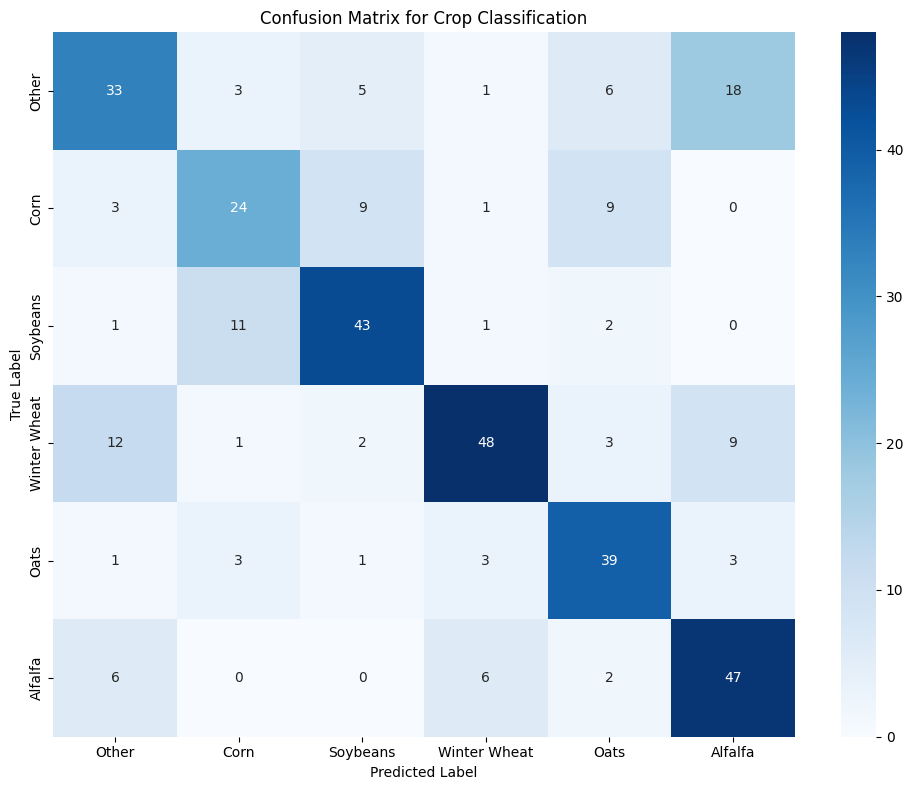

Classification Report:
              precision  recall  f1-score  support
Other             0.589   0.500     0.541   66.000
Corn              0.571   0.522     0.545   46.000
Soybeans          0.717   0.741     0.729   58.000
Winter Wheat      0.800   0.640     0.711   75.000
Oats              0.639   0.780     0.703   50.000
Alfalfa           0.610   0.770     0.681   61.000
accuracy          0.657   0.657     0.657    0.657
macro avg         0.655   0.659     0.652  356.000
weighted avg      0.663   0.657     0.655  356.000
Overall Accuracy: 0.6573


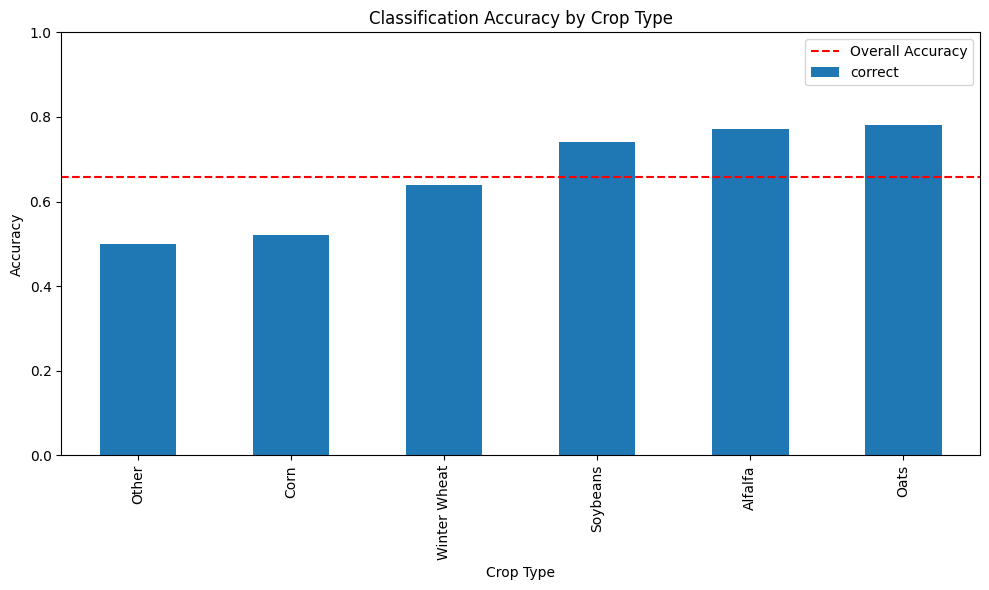


Top Confusion Pairs:
       True Crop Predicted Crop  Count
12         Other        Alfalfa     18
24  Winter Wheat          Other     12
17      Soybeans           Corn     11
21  Winter Wheat        Alfalfa      9
5           Corn       Soybeans      9
3           Corn           Oats      9
2        Alfalfa   Winter Wheat      6
1        Alfalfa          Other      6
14         Other           Oats      6
15         Other       Soybeans      5


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

test_results_csv = '/content/drive/MyDrive/testing_crop_classification_results/crop_classification_test_results.csv'

def analyze_test_results(results_csv):
    results = pd.read_csv(results_csv)

    y_true = results['crop_code']
    y_pred = results['classification']

    labels = [crop_classes[code] for code in sorted(crop_classes.keys())]

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=sorted(crop_classes.keys()))

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=labels,
               yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix for Crop Classification')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300)
    plt.show()

    # Calculate precision, recall, and F1 score
    report = classification_report(y_true, y_pred,
                                  labels=sorted(crop_classes.keys()),
                                  target_names=labels,
                                  output_dict=True)

    report_df = pd.DataFrame(report).transpose()
    print("Classification Report:")
    print(report_df.round(3))

    results['true_crop'] = results['crop_code'].map(crop_classes)
    results['predicted_crop'] = results['classification'].map(crop_classes)
    results['correct'] = results['crop_code'] == results['classification']

    # Overall accuracy
    accuracy = results['correct'].mean()
    print(f"Overall Accuracy: {accuracy:.4f}")

    # Per-class accuracy
    class_accuracy = results.groupby('true_crop')['correct'].mean().sort_values()

    plt.figure(figsize=(10, 6))
    class_accuracy.plot(kind='bar')
    plt.axhline(y=accuracy, color='r', linestyle='--', label='Overall Accuracy')
    plt.xlabel('Crop Type')
    plt.ylabel('Accuracy')
    plt.title('Classification Accuracy by Crop Type')
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.savefig('class_accuracy.png', dpi=300)
    plt.show()

    # Analyze which pairs of classes are most confused
    misclassified = results[~results['correct']]
    confusion_pairs = misclassified.groupby(['true_crop', 'predicted_crop']).size().reset_index()
    confusion_pairs.columns = ['True Crop', 'Predicted Crop', 'Count']
    confusion_pairs = confusion_pairs.sort_values('Count', ascending=False)

    print("\nTop Confusion Pairs:")
    print(confusion_pairs.head(10))

    return report_df, class_accuracy, confusion_pairs

report, class_accuracy, confusion_pairs = analyze_test_results(test_results_csv)

The model performs decently. It would probably perform better if it was trained over the full year's data but I felt that defeated the purpose of the model.

To improve classification of the 'Other' class, running the analysis over each crop code rather than only the top 5 and just grouping the non-target crops as a 6th class would probably be better too.

### Task 3.3: Model Deployment

We're at the end, now it's time to see how our model does over an entire county! Apply the developed crop classification model to full counties to create prediction maps and visually compare against ground truth data.

Key Requirements:

- Script should take any county as an input and produce an output classification.
- Specifically generate output classification results for two counties: (1) Crawford County, Iowa (2) Grant County, Wisconsin. (NOTE we did not train at all in Wisconsin!)
- Run the model over all the pixels of each county.
- Output crop classification maps with predictions at 30 meter resolution.
- Visually compare the model outputs to the Cropland Data Layer (CDL).
- Document any data exports or external processing required.

If your model was built entirely in GEE (recommended), deployment should be straightforward. If your model however was built outside of GEE and you had to export lots of data to run your mode, you may need to ingest results back into GEE (if needed) for visualization and comparison.

Analyze similarities and differences between your model output and the CDL. Do they line up at all? Is your approach viable for real-world deployment? How do the results differ when looked at a much larger geographic scale compared to the test set?

Now to extend our model onto other locations, I kept the DMD results constant as I felt the crop NDVI growth behavior should only vary slightly from location to location.

One thing I could have done is to rerun the entire DMD analysis over the new locations as well and had those as input into the classifier but exporting it took way too long.

This function:

1. Gets the roi of the new counties.
2. Loads the CDL of the county
3. Creates the Landsat composites for early 2019.
4. Adds the various features.
5. Classifies the samples with our trained classifier.

In [ ]:
def classify_county(county_name, state_fips, trained_classifier, results_multi_year, export_to_drive=True):
    county = ee.FeatureCollection('TIGER/2018/Counties') \
        .filter(ee.Filter.And(
            ee.Filter.eq('NAME', county_name),
            ee.Filter.eq('STATEFP', state_fips)
        ))
    county_geometry = county.geometry()

    cdl = ee.Image('USDA/NASS/CDL/2019') \
        .select('cropland') \
        .clip(county_geometry)

    top_5_crop_codes = [1, 5, 36, 24, 28]
    top_crop_mask = ee.Image(0)
    for code in top_5_crop_codes:
        top_crop_mask = top_crop_mask.max(cdl.eq(code))

    other_mask = top_crop_mask.eq(0)
    cdl_with_other = cdl.multiply(top_crop_mask).add(other_mask.multiply(0))

    corn_samples = sample_crop_pixels(1, 500, 'Corn', cdl_with_other, county_geometry)
    soybean_samples = sample_crop_pixels(5, 500, 'Soybeans', cdl_with_other, county_geometry)
    winter_wheat_samples = sample_crop_pixels(24, 500, 'Winter Wheat', cdl_with_other, county_geometry)
    oats_samples = sample_crop_pixels(28, 500, 'Oats', cdl_with_other, county_geometry)
    alfalfa_samples = sample_crop_pixels(36, 500, 'Alfalfa', cdl_with_other, county_geometry)
    other_samples = sample_crop_pixels(0, 500, 'Other', cdl_with_other, county_geometry)

    all_samples = corn_samples \
        .merge(soybean_samples) \
        .merge(winter_wheat_samples) \
        .merge(oats_samples) \
        .merge(alfalfa_samples) \
        .merge(other_samples)

    landsat = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
        .filterDate(early_mid_season['start'], early_mid_season['end'])
        .filterBounds(county_geometry)
        .map(mask_l8_clouds)
        .map(add_indices)
    )

    march = landsat.filterDate('2019-03-01', '2019-03-31')
    april = landsat.filterDate('2019-04-01', '2019-04-30')
    may = landsat.filterDate('2019-05-01', '2019-05-31')
    june = landsat.filterDate('2019-06-01', '2019-06-30')
    july = landsat.filterDate('2019-07-01', '2019-07-31')

    march_features = create_monthly_features(march, 'march')
    april_features = create_monthly_features(april, 'april')
    may_features = create_monthly_features(may, 'may')
    june_features = create_monthly_features(june, 'june')
    july_features = create_monthly_features(july, 'july')

    composites_list = [march_features, april_features, may_features, june_features, july_features]
    composites_list = [comp for comp in composites_list if comp is not None]

    all_features = ee.Image.cat(composites_list)
    all_features = add_phenology_features(all_features)

    with open('dmd_feature_names.pkl', 'rb') as f:
        dmd_feature_names = pickle.load(f)


    all_features = add_dmd_features_to_classifier(
        all_features,
        results_multi_year,
        top_5_crop_codes,
        crop_legend,
        training_features=dmd_feature_names
    )

    feature_bands = all_features.bandNames()

    sampled_features = all_features.sampleRegions(
        collection=all_samples,
        properties=['crop_code'],
        scale=30,
        tileScale=8
    )

    without_null = sampled_features.filter(ee.Filter.notNull(feature_bands))

    classified_samples = without_null.classify(trained_classifier)

    sample_points_image = ee.Image().paint(classified_samples, 'classification')

    if export_to_drive:
        filename = f"{county_name}_{state_fips}_classification"
        export_task = ee.batch.Export.table.toDrive(
            collection=classified_samples,
            description=filename,
            folder='crop_classification_results',
            fileNamePrefix=filename,
            fileFormat='CSV'
        )

        export_task.start()

        ref_filename = f"{county_name}_{state_fips}_reference"
        ref_export_task = ee.batch.Export.table.toDrive(
            collection=all_samples,
            description=ref_filename,
            folder='crop_classification_results',
            fileNamePrefix=ref_filename,
            fileFormat='CSV'
        )

        ref_export_task.start()

    return {
        'classified': sample_points_image,
        'cdl': cdl_with_other,
        'geometry': county_geometry,
        'county_name': county_name,
        'state_fips': state_fips,
        'classified_samples': classified_samples,
        'all_samples': all_samples,
        'export_filename': f"{county_name}_{state_fips}_classification" if export_to_drive else None,
        'ref_filename': f"{county_name}_{state_fips}_reference" if export_to_drive else None
    }

We evaluate the results in a similar manner as before.

In [ ]:
def evaluate_county_classification_from_drive(county_name, state_fips, drive_path=None):
    state_name = 'Iowa' if state_fips == '19' else 'Wisconsin'

    if drive_path is None:
        drive_path = f"/content/drive/MyDrive/crop_classification_results/{county_name}_{state_fips}_classification.csv"

    classified_df = pd.read_csv(drive_path)

    confusion_matrix = pd.crosstab(
        classified_df['crop_code'],
        classified_df['classification'],
        rownames=['Actual'],
        colnames=['Predicted']
    )

    total = confusion_matrix.sum().sum()
    correct = sum(confusion_matrix.values[i, i] for i in range(min(confusion_matrix.shape)))
    overall_accuracy = correct / total if total > 0 else 0

    class_names = {
        0: 'Other',
        1: 'Corn',
        5: 'Soybeans',
        24: 'Winter Wheat',
        28: 'Oats',
        36: 'Alfalfa'
    }

    confusion_matrix = confusion_matrix.rename(
        index=class_names,
        columns=class_names
    )

    plt.figure(figsize=(10, 8))
    heatmap = sns.heatmap(
        confusion_matrix,
        annot=True,
        fmt='d',
        cmap='Blues',
        cbar_kws={'label': 'Count'},
        square=True,
        linewidths=0.5
    )

    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.title(f'Confusion Matrix - {county_name} County, {state_name}')
    plt.tight_layout()
    plt.show()

    return {
        'overall_accuracy': overall_accuracy,
        'confusion_matrix': confusion_matrix
    }

For visualization purposes, we plot the CDL, the samples, and our classification.

In [ ]:
def visualize_comparison_from_drive(county_name, state_fips, classification_path=None, reference_path=None):
    import pandas as pd
    import geemap
    import ee
    import json

    state_name = 'Iowa' if state_fips == '19' else 'Wisconsin'

    if classification_path is None:
        classification_path = f"/content/drive/MyDrive/crop_classification_results/{county_name}_{state_fips}_classification.csv"
    if reference_path is None:
        reference_path = f"/content/drive/MyDrive/crop_classification_results/{county_name}_{state_fips}_reference.csv"

    county = ee.FeatureCollection('TIGER/2018/Counties') \
        .filter(ee.Filter.And(
            ee.Filter.eq('NAME', county_name),
            ee.Filter.eq('STATEFP', state_fips)
        ))
    county_geometry = county.geometry()

    cdl = ee.Image('USDA/NASS/CDL/2019') \
        .select('cropland') \
        .clip(county_geometry)

    top_5_crop_codes = [1, 5, 24, 28, 36]
    other_mask = cdl.remap(
        top_5_crop_codes,
        ee.List.repeat(0, len(top_5_crop_codes)),
        1
    )
    cdl_with_other = cdl.multiply(ee.Image(1).subtract(other_mask)) \
        .add(other_mask.multiply(0))

    classified_df = pd.read_csv(classification_path)
    reference_df = pd.read_csv(reference_path)

    m = geemap.Map()
    m.centerObject(county_geometry, 10)

    crop_vis = {
        'min': 0,
        'max': 36,
        'palette': [
            'gray',
            'yellow',
            'darkgreen',
            'brown',
            'orange',
            'purple'
        ]
    }
    m.addLayer(cdl_with_other, crop_vis, 'CDL 2019 (Reference)', True)

    class_names = {
        0: 'Other',
        1: 'Corn',
        5: 'Soybeans',
        24: 'Winter Wheat',
        28: 'Oats',
        36: 'Alfalfa'
    }

    if '.geo' in classified_df.columns:
        # Get coords form geo column
        def extract_coords(geo_str):
            try:
                geo_data = json.loads(geo_str.replace("'", '"'))
                coords = geo_data['coordinates']
                return coords[0], coords[1]
            except:
                return None, None

        classified_df['lon'], classified_df['lat'] = zip(*classified_df['.geo'].apply(extract_coords))
        reference_df['lon'], reference_df['lat'] = zip(*reference_df['.geo'].apply(extract_coords))
    else:
        print("'.geo' column not found and no coordinate columns available")
        return None


    for class_code, color in zip([0, 1, 5, 24, 28, 36], crop_vis['palette']):
        class_name = class_names[class_code]

        class_points = reference_df[reference_df['crop_code'] == class_code]

        if not class_points.empty:

            features = []
            for idx, row in class_points.iterrows():
                if pd.notna(row['lon']) and pd.notna(row['lat']):
                    point = ee.Geometry.Point([row['lon'], row['lat']])
                    feature = ee.Feature(point, {'crop_code': row['crop_code'], 'crop_name': class_name})
                    features.append(feature)

            if features:
                class_fc = ee.FeatureCollection(features)
                m.addLayer(class_fc, {'color': color}, f'Samples: {class_name}', False)

    classified_features = []
    for idx, row in classified_df.iterrows():
        if pd.notna(row['lon']) and pd.notna(row['lat']):
            point = ee.Geometry.Point([row['lon'], row['lat']])
            feature = ee.Feature(point, {
                'crop_code': row['crop_code'],
                'classification': row['classification']
            })
            classified_features.append(feature)

    if classified_features:
        classified_fc = ee.FeatureCollection(classified_features)
        m.addLayer(classified_fc, {'color': 'red'}, 'Classified Points', True)

    import matplotlib.colors as mcolors
    colors = crop_vis['palette']
    legend_dict = {}
    for i, (code, name) in enumerate(class_names.items()):
        if i < len(colors):
            rgb = tuple(int(255 * x) for x in mcolors.to_rgb(colors[i]))
            legend_dict[name] = rgb

    m.add_legend(title="Crop Types", legend_dict=legend_dict)

    return m

I export the references and classified files.

In [ ]:
def deploy_model_to_counties(trained_classifier, results_multi_year):
    results = {}

    grant_result = classify_county(
        county_name='Grant',
        state_fips='55',
        trained_classifier=trained_classifier,
        results_multi_year=results_multi_year,
        export_to_drive=True
    )
    results['grant_export_filename'] = grant_result['export_filename']
    results['grant_ref_filename'] = grant_result['ref_filename']


    crawford_result = classify_county(
        county_name='Crawford',
        state_fips='19',
        trained_classifier=trained_classifier,
        results_multi_year=results_multi_year,
        export_to_drive=True
    )
    results['crawford_export_filename'] = crawford_result['export_filename']
    results['crawford_ref_filename'] = crawford_result['ref_filename']

    return results

Performing the results analysis.

In [ ]:
def analyze_classification_results(counties=['Crawford', 'Grant'], state_fips=['19', '55']):
    results = {}

    for county, fips in zip(counties, state_fips):
        metrics = evaluate_county_classification_from_drive(county, fips)
        if metrics:
            results[f'{county.lower()}_metrics'] = metrics

            map_viz = visualize_comparison_from_drive(county, fips)
            if map_viz:
                display(map_viz)
                results[f'{county.lower()}_map'] = map_viz

    if 'crawford_metrics' in results and 'grant_metrics' in results:
        print("\nComparison of Model Performance:")
        print(f"Crawford County, IA: {results['crawford_metrics']['overall_accuracy']:.4f}")
        print(f"Grant County, WI: {results['grant_metrics']['overall_accuracy']:.4f}")
    return results

In [ ]:
results = deploy_model_to_counties(
    trained_classifier=trained_classifier,
    results_multi_year=results_multi_year
)

Adding DMD features with consistency checks...
Running in deployment mode with 175 expected features
Added 175 DMD features in deployment mode
Adding DMD features with consistency checks...
Running in deployment mode with 175 expected features
Added 175 DMD features in deployment mode


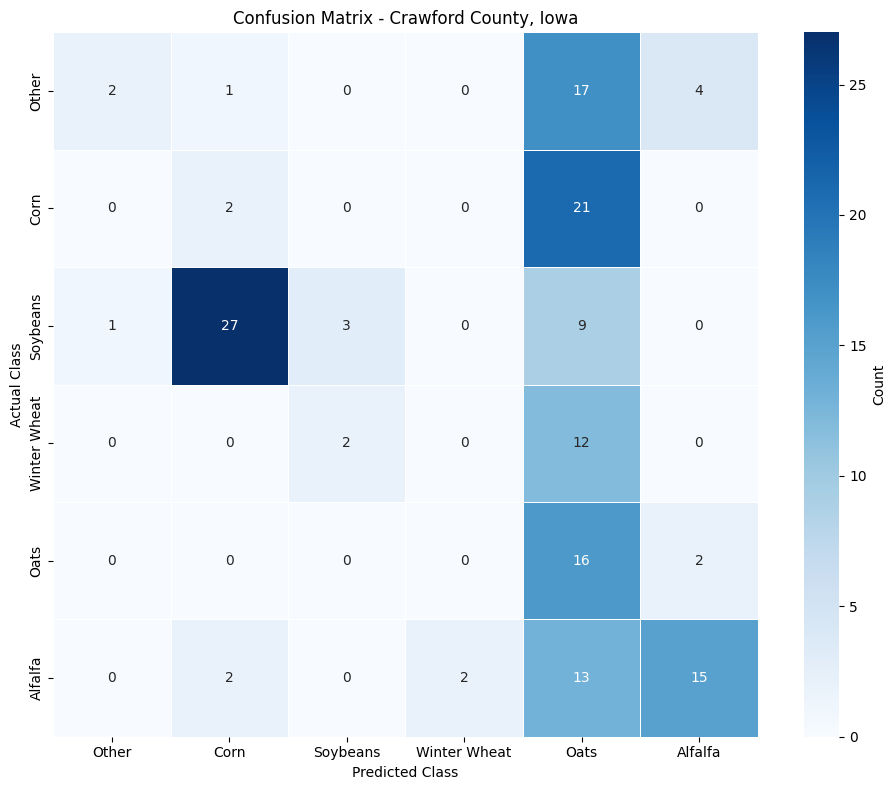

Map(center=[42.03717547065044, -95.38196911720159], controls=(WidgetControl(options=['position', 'transparent_…

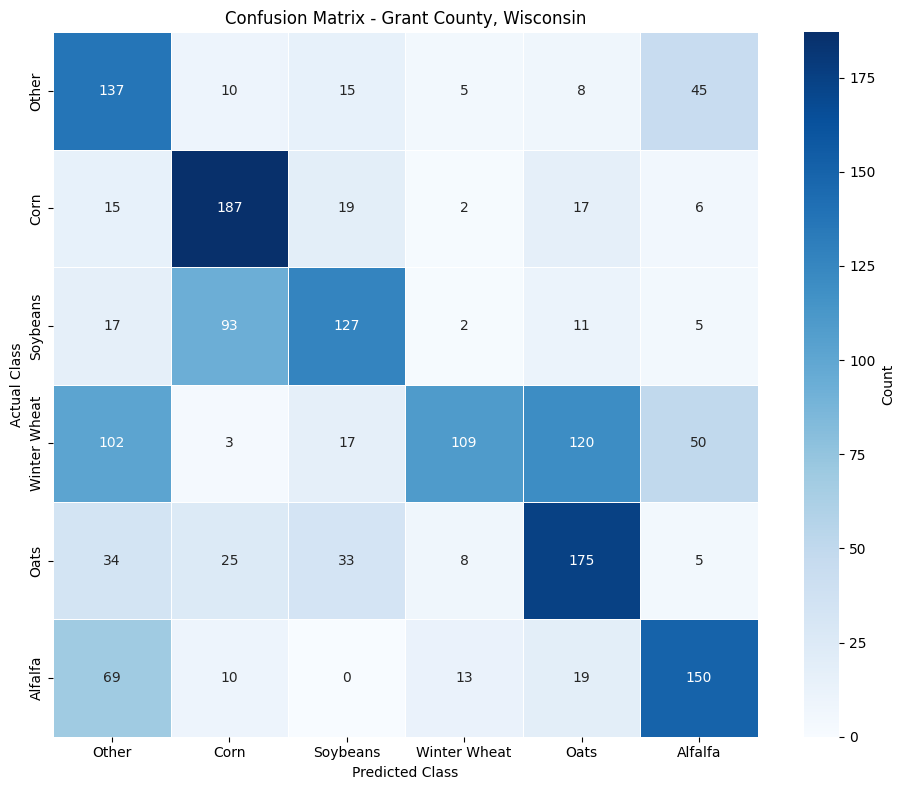

Map(center=[42.86719597795384, -90.70615105710115], controls=(WidgetControl(options=['position', 'transparent_…


Comparison of Model Performance:
Crawford County, IA: 0.2517
Grant County, WI: 0.5322


In [ ]:
analysis = analyze_classification_results()

The results for Crawford county was worse than I expected but most likely due to how the crops are distributed and the small variety of crops there. The model performed better in Grant county most likely due how it is distributed and more crop points to work with.

Overall, there is a lot of improvement that I could have done to make the model better. And although it was very tedious and excrutiating to debug, I have learned a lot from this assignment.

I have also developed a hate towards .getInfo() and exporting data.